# Capacity allocation

## 0. Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from benchmarks.generator import get_revenue_behavior, get_revenue_behavior_deprecated
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, infer_line_stations, get_services_by_tsp_df, plot_marey_chart
from src.entities import GSA, Solution

from robin.scraping.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from pathlib import Path
from typing import Any, List, Mapping, Tuple, Union
import shutil

In [2]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/mealpy/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

#if Path(figures).exists():
#    shutil.rmtree(figures)
#Path(figures).mkdir(parents=True)

In [3]:
seed = 21

if generator_config_path:
    n_services = int_input("Number of services to generate: ")
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(file_name=generator_save_path,
                           path_config=generator_config_path,
                           n_services=n_services,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 50


In [4]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)

print(tsp_df)

     Number of Services
RU2                   5
RU3                  12
RU1                  12
RU4                  13
RU5                   8


In [5]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behaviour = get_revenue_behavior_deprecated(supply)
lines = supply.lines
line = infer_line_stations(lines)

Services:  50


C:\Users\hyper\PycharmProjects\GSA_M\.venv\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


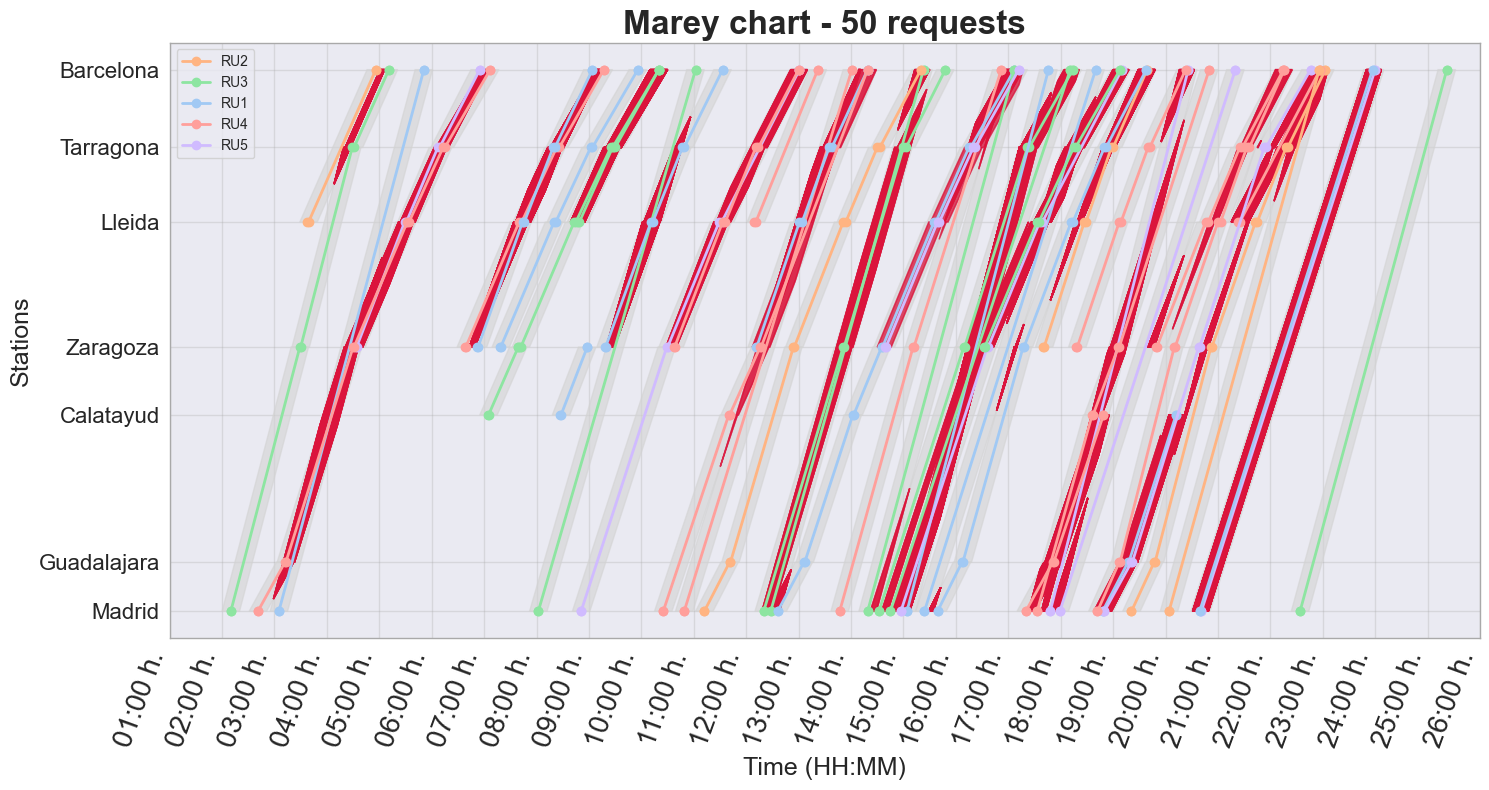

In [6]:
plot_marey_chart(requested_supply=supply,
                 colors_by_tsp=True, 
                 main_title=f"Marey chart - {n_services} requests",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/mealpy/marey_chart_requests_25.pdf'))

## 1. Mealpy

In [7]:
from src.timetabling_problem import MPTT

mptt = MPTT(
    requested_schedule=requested_schedule,
    revenue_behavior=revenue_behaviour,
    line=line,
    safe_headway=10
)

In [8]:
from mealpy.evolutionary_based import DE, ES, GA
from mealpy.swarm_based import ABC, ACOR, GWO, PSO, WOA
from mealpy.physics_based import SA

mp_algos = {
    "Genetic Algorithm": GA.BaseGA,
    "Particle Swarm Optimization": PSO.OriginalPSO,
    "Simulated Annealing": SA.OriginalSA,
    "Differential Evolution": DE.OriginalDE,
    "Ant Colony Optimization Continuous (ACOR)": ACOR.OriginalACOR,
    "Covariance Matrix Adaptation Evolution Strategy": ES.CMA_ES,
    "Artificial Bee Colony": ABC.OriginalABC,
    "Grey Wolf Optimizer": GWO.OriginalGWO,
    "Whale Optimization Algorithm": WOA.OriginalWOA,
    "Hybrid Grey Wolf - Whale Optimization Algorithm": GWO.GWO_WOA
}

In [9]:
from mealpy import IntegerVar

runs = 5
epochs = 100
pop_size = 50

seed_initializer = 29

# 0. Problem formulation
lb, ub = zip(*mptt.boundaries.real)

problem = {"obj_func": mptt.objective_function,
           "bounds": IntegerVar(lb=lb,
                              ub=ub),
           "minmax": "max",
           "save_population": True}

# 1. Iter algorithms
df_history = pd.DataFrame()
df_population = pd.DataFrame()

for algo_name, algo in mp_algos.items():
    
    # Re-initialize seed
    np.random.seed(seed_initializer)
    
    print(f"Running {algo_name}")
    for r in range(1, runs+1):
        print("\tRun: ", r)
        
        run_seed = np.random.randint(0, 1000)
        
        # Run algorithm
        if algo_name == "Simulated Annealing":
            optimizer = algo(epoch=epochs*pop_size)
            optimizer.solve(problem, seed=run_seed)
        else:
            optimizer = algo(epoch=epochs, pop_size=pop_size)
            optimizer.solve(problem, seed=run_seed)
            
        # Build run history dataframe
        columns = ['Algo', 'Iteration', 'Fitness', 'ExecutionTime', 'Discrete', 'Real', 
                   'Diversity', 'Exploitation', 'Exploration']
        run_history = pd.DataFrame(columns=columns)
        
        # Save optimizer history to dataframe
        for i, data in enumerate(optimizer.history.list_global_best):
            mptt.update_schedule(data.solution)
            run_history.loc[i] = [algo_name,
                                  i, 
                                  data.target.fitness,
                                  optimizer.history.list_epoch_time[i],
                                  mptt.get_heuristic_schedule_old(),
                                  data.solution,
                                  optimizer.history.list_diversity[i],
                                  optimizer.history.list_exploitation[i],
                                  optimizer.history.list_exploration[i]]
    
        run_history.insert(0, "Run", r)
        df_history = pd.concat([df_history, run_history], axis=0)
        
        # Population dataframe
        if algo_name == "Simulated Annealing":
            continue
        
        population_colums = [f'real_{i}' for i in range(pop_size)] + [f'discrete_{i}' for i in range(pop_size)]
        population_colums.insert(0, 'Iteration')
        run_population = pd.DataFrame(columns=population_colums)
        
        for i, pop_epoch in enumerate(optimizer.history.list_population):
            population_row = [i]
            real = []
            discrete = [] 
            for individual in pop_epoch:
                mptt.update_schedule(individual.solution)
                real.append(individual.solution)
                discrete.append(mptt.get_heuristic_schedule_old())
            
            population_row = [i, *real, *discrete]
            run_population.loc[len(run_population)] = population_row
        
        run_population.insert(0, "Run", r)
        run_population.insert(1, "Algo", algo_name)
        df_population = pd.concat([df_population, run_population], axis=0)    

2025/05/15 11:28:54 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: Solving single objective optimization problem.


Running Genetic Algorithm
	Run:  1


2025/05/15 11:28:56 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2818.9880825032146, Global best: 2818.9880825032146, Runtime: 0.81483 seconds
2025/05/15 11:28:57 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2984.5603036553057, Global best: 2984.5603036553057, Runtime: 0.81975 seconds
2025/05/15 11:28:58 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 3339.284098878853, Global best: 3339.284098878853, Runtime: 0.81172 seconds
2025/05/15 11:28:59 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 4039.305060298017, Global best: 4039.305060298017, Runtime: 0.80560 seconds
2025/05/15 11:28:59 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3906.9043437705354, Global best: 4039.305060298017, Runtime: 0.81174 seconds
2025/05/15 11:29:00 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epo

	Run:  2


2025/05/15 11:31:34 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2624.255204291711, Global best: 2624.255204291711, Runtime: 0.79722 seconds
2025/05/15 11:31:35 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 3222.0793720659226, Global best: 3222.0793720659226, Runtime: 0.79843 seconds
2025/05/15 11:31:36 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 3425.490880346435, Global best: 3425.490880346435, Runtime: 0.82104 seconds
2025/05/15 11:31:37 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3585.072051072654, Global best: 3585.072051072654, Runtime: 0.79490 seconds
2025/05/15 11:31:37 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3917.3132618554314, Global best: 3917.3132618554314, Runtime: 0.79017 seconds
2025/05/15 11:31:38 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoc

	Run:  3


2025/05/15 11:34:14 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2471.9920181341236, Global best: 2471.9920181341236, Runtime: 0.78892 seconds
2025/05/15 11:34:15 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2795.2299324592072, Global best: 2795.2299324592072, Runtime: 0.79755 seconds
2025/05/15 11:34:16 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2934.277254468928, Global best: 2934.277254468928, Runtime: 0.80017 seconds
2025/05/15 11:34:16 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3192.2542666251748, Global best: 3192.2542666251748, Runtime: 0.79762 seconds
2025/05/15 11:34:17 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3117.438199921435, Global best: 3192.2542666251748, Runtime: 0.79573 seconds
2025/05/15 11:34:18 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, E

	Run:  4


2025/05/15 11:36:53 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2799.668960771344, Global best: 2799.668960771344, Runtime: 0.78752 seconds
2025/05/15 11:36:54 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 3479.616942503111, Global best: 3479.616942503111, Runtime: 0.78345 seconds
2025/05/15 11:36:55 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 3302.6474921613258, Global best: 3479.616942503111, Runtime: 0.78401 seconds
2025/05/15 11:36:56 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3869.7920424814006, Global best: 3869.7920424814006, Runtime: 0.78375 seconds
2025/05/15 11:36:56 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3764.51477081613, Global best: 3869.7920424814006, Runtime: 0.78776 seconds
2025/05/15 11:36:57 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch

	Run:  5


2025/05/15 11:39:40 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2479.2649269091594, Global best: 2479.2649269091594, Runtime: 0.79533 seconds
2025/05/15 11:39:40 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2744.396355466764, Global best: 2744.396355466764, Runtime: 0.84568 seconds
2025/05/15 11:39:41 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2999.414606226741, Global best: 2999.414606226741, Runtime: 0.83181 seconds
2025/05/15 11:39:42 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3659.9463079847105, Global best: 3659.9463079847105, Runtime: 0.85959 seconds
2025/05/15 11:39:43 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3497.448189175314, Global best: 3659.9463079847105, Runtime: 0.84566 seconds
2025/05/15 11:39:44 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epo

Running Particle Swarm Optimization
	Run:  1


2025/05/15 11:42:20 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 2557.851168226272, Global best: 2557.851168226272, Runtime: 0.80586 seconds
2025/05/15 11:42:21 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 2557.851168226272, Global best: 2557.851168226272, Runtime: 0.81409 seconds
2025/05/15 11:42:22 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 2735.611968008177, Global best: 2735.611968008177, Runtime: 0.80519 seconds
2025/05/15 11:42:23 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 2735.611968008177, Global best: 2735.611968008177, Runtime: 0.81107 seconds
2025/05/15 11:42:24 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 2735.611968008177, Global best: 2735.611968008177, Runtime: 0.80437 seconds
2025/05/15 11:42:25 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 6, Curr

	Run:  2


2025/05/15 11:44:59 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 2745.024094652318, Global best: 2745.024094652318, Runtime: 0.79953 seconds
2025/05/15 11:45:00 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 2745.024094652318, Global best: 2745.024094652318, Runtime: 0.79006 seconds
2025/05/15 11:45:00 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 2819.2673372794607, Global best: 2819.2673372794607, Runtime: 0.79142 seconds
2025/05/15 11:45:01 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 3157.523542221974, Global best: 3157.523542221974, Runtime: 0.79872 seconds
2025/05/15 11:45:02 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 3157.523542221974, Global best: 3157.523542221974, Runtime: 0.80157 seconds
2025/05/15 11:45:03 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 6, Cu

	Run:  3


2025/05/15 11:47:37 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 2437.7873075875987, Global best: 2437.7873075875987, Runtime: 0.79442 seconds
2025/05/15 11:47:38 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 2973.9443251498183, Global best: 2973.9443251498183, Runtime: 0.79889 seconds
2025/05/15 11:47:38 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 2973.9443251498183, Global best: 2973.9443251498183, Runtime: 0.79089 seconds
2025/05/15 11:47:39 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 2996.384225670833, Global best: 2996.384225670833, Runtime: 0.79742 seconds
2025/05/15 11:47:40 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 2996.384225670833, Global best: 2996.384225670833, Runtime: 0.78649 seconds
2025/05/15 11:47:41 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 6

	Run:  4


2025/05/15 11:50:17 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 2790.6813201806826, Global best: 2790.6813201806826, Runtime: 0.79551 seconds
2025/05/15 11:50:18 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 3049.422331969357, Global best: 3049.422331969357, Runtime: 0.80110 seconds
2025/05/15 11:50:19 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 3049.422331969357, Global best: 3049.422331969357, Runtime: 0.79638 seconds
2025/05/15 11:50:20 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 3049.422331969357, Global best: 3049.422331969357, Runtime: 0.80931 seconds
2025/05/15 11:50:20 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 3049.422331969357, Global best: 3049.422331969357, Runtime: 0.82200 seconds
2025/05/15 11:50:21 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 6, Cu

	Run:  5


2025/05/15 11:52:56 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 2999.544394352921, Global best: 2999.544394352921, Runtime: 0.79797 seconds
2025/05/15 11:52:57 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 2999.544394352921, Global best: 2999.544394352921, Runtime: 0.80192 seconds
2025/05/15 11:52:58 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 2999.544394352921, Global best: 2999.544394352921, Runtime: 0.80484 seconds
2025/05/15 11:52:59 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 3213.4816653482276, Global best: 3213.4816653482276, Runtime: 0.80226 seconds
2025/05/15 11:53:00 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 3213.4816653482276, Global best: 3213.4816653482276, Runtime: 0.80073 seconds
2025/05/15 11:53:00 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 6, 

Running Simulated Annealing
	Run:  1


2025/05/15 11:55:31 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 10, Current best: 2024.8756174097612, Global best: 2024.8756174097612, Runtime: 0.01607 seconds
2025/05/15 11:55:31 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 11, Current best: 2024.8756174097612, Global best: 2024.8756174097612, Runtime: 0.01572 seconds
2025/05/15 11:55:31 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 12, Current best: 2024.8756174097612, Global best: 2024.8756174097612, Runtime: 0.01561 seconds
2025/05/15 11:55:31 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 13, Current best: 2024.8756174097612, Global best: 2024.8756174097612, Runtime: 0.01554 seconds
2025/05/15 11:55:31 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 14, Current best: 2024.8756174097612, Global best: 2024.8756174097612, Runtime: 0.01554 seconds
2025/05/15 11:55:31 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P,

	Run:  2


2025/05/15 11:58:11 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 8, Current best: 1810.6724201511038, Global best: 1810.6724201511038, Runtime: 0.01625 seconds
2025/05/15 11:58:11 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 9, Current best: 1810.6724201511038, Global best: 1810.6724201511038, Runtime: 0.01628 seconds
2025/05/15 11:58:11 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 10, Current best: 1810.6724201511038, Global best: 1810.6724201511038, Runtime: 0.01660 seconds
2025/05/15 11:58:11 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 11, Current best: 2137.9310708167936, Global best: 2137.9310708167936, Runtime: 0.01580 seconds
2025/05/15 11:58:11 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 12, Current best: 2138.416346757874, Global best: 2138.416346757874, Runtime: 0.01622 seconds
2025/05/15 11:58:11 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epo

	Run:  3


2025/05/15 12:00:50 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 9, Current best: 1139.3414015052222, Global best: 1139.3414015052222, Runtime: 0.01592 seconds
2025/05/15 12:00:50 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 10, Current best: 1139.3414015052222, Global best: 1139.3414015052222, Runtime: 0.01573 seconds
2025/05/15 12:00:50 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 11, Current best: 1139.3414015052222, Global best: 1139.3414015052222, Runtime: 0.01616 seconds
2025/05/15 12:00:50 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 12, Current best: 1139.3414015052222, Global best: 1139.3414015052222, Runtime: 0.01554 seconds
2025/05/15 12:00:50 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 13, Current best: 1139.3414015052222, Global best: 1139.3414015052222, Runtime: 0.01625 seconds
2025/05/15 12:00:50 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, 

	Run:  4


2025/05/15 12:03:29 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 8, Current best: 1560.211461626546, Global best: 1560.211461626546, Runtime: 0.01609 seconds
2025/05/15 12:03:29 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 9, Current best: 1560.211461626546, Global best: 1560.211461626546, Runtime: 0.01647 seconds
2025/05/15 12:03:29 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 10, Current best: 1560.211461626546, Global best: 1560.211461626546, Runtime: 0.01739 seconds
2025/05/15 12:03:29 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 11, Current best: 1560.211461626546, Global best: 1560.211461626546, Runtime: 0.01708 seconds
2025/05/15 12:03:29 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 12, Current best: 1560.211461626546, Global best: 1560.211461626546, Runtime: 0.01665 seconds
2025/05/15 12:03:29 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 13, 

	Run:  5


2025/05/15 12:06:09 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 8, Current best: 1278.109453508345, Global best: 1278.109453508345, Runtime: 0.01572 seconds
2025/05/15 12:06:09 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 9, Current best: 1278.109453508345, Global best: 1278.109453508345, Runtime: 0.01719 seconds
2025/05/15 12:06:09 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 10, Current best: 1278.109453508345, Global best: 1278.109453508345, Runtime: 0.01662 seconds
2025/05/15 12:06:09 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 11, Current best: 1278.109453508345, Global best: 1278.109453508345, Runtime: 0.01668 seconds
2025/05/15 12:06:09 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 12, Current best: 1278.109453508345, Global best: 1278.109453508345, Runtime: 0.01603 seconds
2025/05/15 12:06:09 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 13, 

Running Differential Evolution
	Run:  1


2025/05/15 12:08:54 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 1, Current best: 2289.375673729484, Global best: 2289.375673729484, Runtime: 0.80502 seconds
2025/05/15 12:08:55 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 2, Current best: 2528.765826390793, Global best: 2528.765826390793, Runtime: 0.81270 seconds
2025/05/15 12:08:56 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 3, Current best: 3119.45691658491, Global best: 3119.45691658491, Runtime: 0.80902 seconds
2025/05/15 12:08:56 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 4, Current best: 3119.45691658491, Global best: 3119.45691658491, Runtime: 0.79667 seconds
2025/05/15 12:08:57 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 5, Current best: 3119.45691658491, Global best: 3119.45691658491, Runtime: 0.80188 seconds
2025/05/15 12:08:58 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Pr

	Run:  2


2025/05/15 12:11:32 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 1, Current best: 2451.953904151869, Global best: 2451.953904151869, Runtime: 0.77740 seconds
2025/05/15 12:11:33 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 2, Current best: 2451.953904151869, Global best: 2451.953904151869, Runtime: 0.79366 seconds
2025/05/15 12:11:34 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 3, Current best: 2451.953904151869, Global best: 2451.953904151869, Runtime: 0.77640 seconds
2025/05/15 12:11:35 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 4, Current best: 2451.953904151869, Global best: 2451.953904151869, Runtime: 0.77363 seconds
2025/05/15 12:11:35 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 5, Current best: 2738.2186659551408, Global best: 2738.2186659551408, Runtime: 0.77564 seconds
2025/05/15 12:11:36 PM, INFO, mealpy.evolutionary_based.DE.OriginalD

	Run:  3


2025/05/15 12:14:08 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 1, Current best: 2385.0424668751643, Global best: 2385.0424668751643, Runtime: 0.78465 seconds
2025/05/15 12:14:09 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 2, Current best: 2754.408017471487, Global best: 2754.408017471487, Runtime: 0.79562 seconds
2025/05/15 12:14:09 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 3, Current best: 2754.408017471487, Global best: 2754.408017471487, Runtime: 0.78070 seconds
2025/05/15 12:14:10 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 4, Current best: 2754.408017471487, Global best: 2754.408017471487, Runtime: 0.79028 seconds
2025/05/15 12:14:11 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 5, Current best: 2828.611288846152, Global best: 2828.611288846152, Runtime: 0.77340 seconds
2025/05/15 12:14:12 PM, INFO, mealpy.evolutionary_based.DE.OriginalD

	Run:  4


2025/05/15 12:16:45 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 1, Current best: 2790.6813201806826, Global best: 2790.6813201806826, Runtime: 0.78967 seconds
2025/05/15 12:16:46 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 2, Current best: 2790.6813201806826, Global best: 2790.6813201806826, Runtime: 0.78712 seconds
2025/05/15 12:16:46 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 3, Current best: 2900.1878206772353, Global best: 2900.1878206772353, Runtime: 0.78548 seconds
2025/05/15 12:16:47 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 4, Current best: 2900.1878206772353, Global best: 2900.1878206772353, Runtime: 0.78462 seconds
2025/05/15 12:16:48 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 5, Current best: 2924.570020875893, Global best: 2924.570020875893, Runtime: 0.78920 seconds
2025/05/15 12:16:49 PM, INFO, mealpy.evolutionary_based.DE.Ori

	Run:  5


2025/05/15 12:19:23 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 1, Current best: 2172.346492668993, Global best: 2172.346492668993, Runtime: 0.77674 seconds
2025/05/15 12:19:23 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 2, Current best: 2330.5695371939455, Global best: 2330.5695371939455, Runtime: 0.78259 seconds
2025/05/15 12:19:24 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 3, Current best: 2448.6212632557326, Global best: 2448.6212632557326, Runtime: 0.78803 seconds
2025/05/15 12:19:25 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 4, Current best: 2460.780572656001, Global best: 2460.780572656001, Runtime: 0.78772 seconds
2025/05/15 12:19:26 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 5, Current best: 2801.3921145826557, Global best: 2801.3921145826557, Runtime: 0.78487 seconds
2025/05/15 12:19:27 PM, INFO, mealpy.evolutionary_based.DE.Origi

Running Ant Colony Optimization Continuous (ACOR)
	Run:  1


2025/05/15 12:21:57 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 2078.765409445966, Global best: 2078.765409445966, Runtime: 0.44540 seconds
2025/05/15 12:21:58 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 2078.765409445966, Global best: 2078.765409445966, Runtime: 0.45134 seconds
2025/05/15 12:21:58 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 2078.765409445966, Global best: 2078.765409445966, Runtime: 0.44313 seconds
2025/05/15 12:21:59 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 2130.3975290919766, Global best: 2130.3975290919766, Runtime: 0.44396 seconds
2025/05/15 12:21:59 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 2130.3975290919766, Global best: 2130.3975290919766, Runtime: 0.44311 seconds
2025/05/15 12:22:00 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P

	Run:  2


2025/05/15 12:24:01 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 2451.953904151869, Global best: 2451.953904151869, Runtime: 0.44642 seconds
2025/05/15 12:24:02 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 2802.6491944341396, Global best: 2802.6491944341396, Runtime: 0.45194 seconds
2025/05/15 12:24:02 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 2802.6491944341396, Global best: 2802.6491944341396, Runtime: 0.45022 seconds
2025/05/15 12:24:03 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 2802.6491944341396, Global best: 2802.6491944341396, Runtime: 0.44681 seconds
2025/05/15 12:24:03 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 2802.6491944341396, Global best: 2802.6491944341396, Runtime: 0.44203 seconds
2025/05/15 12:24:04 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Proble

	Run:  3


2025/05/15 12:26:03 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 2241.0390764860413, Global best: 2241.0390764860413, Runtime: 0.44236 seconds
2025/05/15 12:26:04 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 2530.138552459051, Global best: 2530.138552459051, Runtime: 0.43962 seconds
2025/05/15 12:26:04 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 2557.427204030006, Global best: 2557.427204030006, Runtime: 0.44598 seconds
2025/05/15 12:26:04 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 2557.427204030006, Global best: 2557.427204030006, Runtime: 0.43923 seconds
2025/05/15 12:26:05 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 2557.427204030006, Global best: 2557.427204030006, Runtime: 0.43898 seconds
2025/05/15 12:26:05 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, 

	Run:  4


2025/05/15 12:28:05 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 2790.6813201806826, Global best: 2790.6813201806826, Runtime: 0.45397 seconds
2025/05/15 12:28:06 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 2790.6813201806826, Global best: 2790.6813201806826, Runtime: 0.45341 seconds
2025/05/15 12:28:06 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 2790.6813201806826, Global best: 2790.6813201806826, Runtime: 0.45354 seconds
2025/05/15 12:28:07 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 2790.6813201806826, Global best: 2790.6813201806826, Runtime: 0.45392 seconds
2025/05/15 12:28:07 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 2790.6813201806826, Global best: 2790.6813201806826, Runtime: 0.45441 seconds
2025/05/15 12:28:08 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Prob

	Run:  5


2025/05/15 12:30:09 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 2232.120708707316, Global best: 2232.120708707316, Runtime: 0.44213 seconds
2025/05/15 12:30:10 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 2232.120708707316, Global best: 2232.120708707316, Runtime: 0.45729 seconds
2025/05/15 12:30:10 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 2232.120708707316, Global best: 2232.120708707316, Runtime: 0.44490 seconds
2025/05/15 12:30:11 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 2435.460994180059, Global best: 2435.460994180059, Runtime: 0.44379 seconds
2025/05/15 12:30:11 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 2676.1041293952853, Global best: 2676.1041293952853, Runtime: 0.44617 seconds
2025/05/15 12:30:11 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, 

Running Covariance Matrix Adaptation Evolution Strategy
	Run:  1


2025/05/15 12:32:12 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 1, Current best: 3457.0540073483276, Global best: 3457.0540073483276, Runtime: 1.47008 seconds
2025/05/15 12:32:14 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 2, Current best: 3147.0786525896765, Global best: 3457.0540073483276, Runtime: 2.20667 seconds
2025/05/15 12:32:16 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 3, Current best: 3696.2063110010963, Global best: 3696.2063110010963, Runtime: 2.20916 seconds
2025/05/15 12:32:18 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 4, Current best: 3463.1074801171953, Global best: 3696.2063110010963, Runtime: 2.22343 seconds
2025/05/15 12:32:21 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 5, Current best: 3172.1516673938368, Global best: 3696.2063110010963, Runtime: 2.27362 seconds
2025/05/15 12:32:23 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P

	Run:  2


2025/05/15 12:37:28 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 1, Current best: 2504.1543191133474, Global best: 2504.1543191133474, Runtime: 1.43696 seconds
2025/05/15 12:37:30 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 2, Current best: 3116.092370344791, Global best: 3116.092370344791, Runtime: 2.14906 seconds
2025/05/15 12:37:32 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 3, Current best: 3085.8360700788007, Global best: 3116.092370344791, Runtime: 2.18204 seconds
2025/05/15 12:37:34 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 4, Current best: 2954.6253256237824, Global best: 3116.092370344791, Runtime: 2.16398 seconds
2025/05/15 12:37:36 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 5, Current best: 3050.0142079754773, Global best: 3116.092370344791, Runtime: 2.26517 seconds
2025/05/15 12:37:39 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epo

	Run:  3


2025/05/15 12:42:42 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 1, Current best: 2714.223951489444, Global best: 2714.223951489444, Runtime: 1.44214 seconds
2025/05/15 12:42:44 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 2, Current best: 2755.6830446797817, Global best: 2755.6830446797817, Runtime: 2.22378 seconds
2025/05/15 12:42:46 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 3, Current best: 2489.6968380787685, Global best: 2755.6830446797817, Runtime: 2.20304 seconds
2025/05/15 12:42:49 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 4, Current best: 2439.581585744406, Global best: 2755.6830446797817, Runtime: 2.22073 seconds
2025/05/15 12:42:51 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 5, Current best: 2300.1658838779485, Global best: 2755.6830446797817, Runtime: 2.29235 seconds
2025/05/15 12:42:53 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, E

	Run:  4


2025/05/15 12:47:58 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 1, Current best: 2853.4975171800443, Global best: 2853.4975171800443, Runtime: 1.44736 seconds
2025/05/15 12:48:01 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 2, Current best: 2946.102483989047, Global best: 2946.102483989047, Runtime: 2.19397 seconds
2025/05/15 12:48:03 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 3, Current best: 3326.871756468852, Global best: 3326.871756468852, Runtime: 2.21017 seconds
2025/05/15 12:48:05 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 4, Current best: 3054.1246401150493, Global best: 3326.871756468852, Runtime: 2.21407 seconds
2025/05/15 12:48:07 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 5, Current best: 2885.5164325117266, Global best: 3326.871756468852, Runtime: 2.27558 seconds
2025/05/15 12:48:10 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoc

	Run:  5


2025/05/15 12:54:13 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 1, Current best: 3003.081068271484, Global best: 3003.081068271484, Runtime: 1.96113 seconds
2025/05/15 12:54:16 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 2, Current best: 2774.8812431905235, Global best: 3003.081068271484, Runtime: 2.88583 seconds
2025/05/15 12:54:19 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 3, Current best: 3139.6108392953124, Global best: 3139.6108392953124, Runtime: 2.97613 seconds
2025/05/15 12:54:21 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 4, Current best: 3369.4537316761803, Global best: 3369.4537316761803, Runtime: 2.80075 seconds
2025/05/15 12:54:25 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 5, Current best: 3011.9424206991152, Global best: 3369.4537316761803, Runtime: 3.05354 seconds
2025/05/15 12:54:28 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, E

Running Artificial Bee Colony
	Run:  1


2025/05/15 01:00:42 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 1, Current best: 2256.701498760259, Global best: 2256.701498760259, Runtime: 1.57566 seconds
2025/05/15 01:00:43 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 2, Current best: 2498.306073093972, Global best: 2498.306073093972, Runtime: 1.55824 seconds
2025/05/15 01:00:45 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 3, Current best: 2998.2847780658553, Global best: 2998.2847780658553, Runtime: 1.55041 seconds
2025/05/15 01:00:46 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 4, Current best: 2998.2847780658553, Global best: 2998.2847780658553, Runtime: 1.55524 seconds
2025/05/15 01:00:48 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 5, Current best: 2998.2847780658553, Global best: 2998.2847780658553, Runtime: 1.55993 seconds
2025/05/15 01:00:49 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 6

	Run:  2


2025/05/15 01:04:38 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 1, Current best: 2514.4495630228453, Global best: 2514.4495630228453, Runtime: 1.57268 seconds
2025/05/15 01:04:40 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 2, Current best: 2514.4495630228453, Global best: 2514.4495630228453, Runtime: 1.58071 seconds
2025/05/15 01:04:42 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 3, Current best: 2514.4495630228453, Global best: 2514.4495630228453, Runtime: 1.58130 seconds
2025/05/15 01:04:43 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 4, Current best: 2520.8858954718476, Global best: 2520.8858954718476, Runtime: 1.57167 seconds
2025/05/15 01:04:45 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 5, Current best: 2696.8516978059697, Global best: 2696.8516978059697, Runtime: 1.56968 seconds
2025/05/15 01:04:46 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoc

	Run:  3


2025/05/15 01:08:35 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 1, Current best: 3116.8518803126226, Global best: 3116.8518803126226, Runtime: 1.55405 seconds
2025/05/15 01:08:36 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 2, Current best: 3116.8518803126226, Global best: 3116.8518803126226, Runtime: 1.55585 seconds
2025/05/15 01:08:38 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 3, Current best: 3116.8518803126226, Global best: 3116.8518803126226, Runtime: 1.54382 seconds
2025/05/15 01:08:39 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 4, Current best: 3116.8518803126226, Global best: 3116.8518803126226, Runtime: 1.53760 seconds
2025/05/15 01:08:41 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 5, Current best: 3116.8518803126226, Global best: 3116.8518803126226, Runtime: 1.53926 seconds
2025/05/15 01:08:42 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoc

	Run:  4


2025/05/15 01:12:30 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 1, Current best: 2811.829418625155, Global best: 2811.829418625155, Runtime: 1.55194 seconds
2025/05/15 01:12:31 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 2, Current best: 2811.829418625155, Global best: 2811.829418625155, Runtime: 1.56459 seconds
2025/05/15 01:12:33 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 3, Current best: 2811.829418625155, Global best: 2811.829418625155, Runtime: 1.56497 seconds
2025/05/15 01:12:34 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 4, Current best: 2811.829418625155, Global best: 2811.829418625155, Runtime: 1.56065 seconds
2025/05/15 01:12:36 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 5, Current best: 2811.829418625155, Global best: 2811.829418625155, Runtime: 1.55257 seconds
2025/05/15 01:12:37 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 6, Curr

	Run:  5


2025/05/15 01:16:26 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 1, Current best: 2392.511490930793, Global best: 2392.511490930793, Runtime: 1.58515 seconds
2025/05/15 01:16:28 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 2, Current best: 2392.511490930793, Global best: 2392.511490930793, Runtime: 1.57554 seconds
2025/05/15 01:16:29 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 3, Current best: 2578.8335322073135, Global best: 2578.8335322073135, Runtime: 1.57866 seconds
2025/05/15 01:16:31 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 4, Current best: 3059.9491691841126, Global best: 3059.9491691841126, Runtime: 1.55851 seconds
2025/05/15 01:16:33 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 5, Current best: 3059.9491691841126, Global best: 3059.9491691841126, Runtime: 1.56541 seconds
2025/05/15 01:16:34 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 6

Running Grey Wolf Optimizer
	Run:  1


2025/05/15 01:20:24 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1, Current best: 2415.4708803954913, Global best: 2415.4708803954913, Runtime: 0.77488 seconds
2025/05/15 01:20:25 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 2, Current best: 2877.7340115608167, Global best: 2877.7340115608167, Runtime: 0.79048 seconds
2025/05/15 01:20:26 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 3, Current best: 2877.7340115608167, Global best: 2877.7340115608167, Runtime: 0.78574 seconds
2025/05/15 01:20:27 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 4, Current best: 2877.7340115608167, Global best: 2877.7340115608167, Runtime: 0.78362 seconds
2025/05/15 01:20:28 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 5, Current best: 2877.7340115608167, Global best: 2877.7340115608167, Runtime: 0.77877 seconds
2025/05/15 01:20:28 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoc

	Run:  2


2025/05/15 01:23:00 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1, Current best: 3156.458297315007, Global best: 3156.458297315007, Runtime: 0.78373 seconds
2025/05/15 01:23:00 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 2, Current best: 3156.458297315007, Global best: 3156.458297315007, Runtime: 0.77962 seconds
2025/05/15 01:23:01 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 3, Current best: 3156.458297315007, Global best: 3156.458297315007, Runtime: 0.77989 seconds
2025/05/15 01:23:02 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 4, Current best: 3156.458297315007, Global best: 3156.458297315007, Runtime: 0.78717 seconds
2025/05/15 01:23:03 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 5, Current best: 3156.458297315007, Global best: 3156.458297315007, Runtime: 0.78773 seconds
2025/05/15 01:23:04 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 6, Curr

	Run:  3


2025/05/15 01:25:33 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1, Current best: 2379.058135521987, Global best: 2379.058135521987, Runtime: 0.77297 seconds
2025/05/15 01:25:34 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 2, Current best: 2757.139632409924, Global best: 2757.139632409924, Runtime: 0.76751 seconds
2025/05/15 01:25:35 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 3, Current best: 2757.139632409924, Global best: 2757.139632409924, Runtime: 0.76985 seconds
2025/05/15 01:25:35 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 4, Current best: 2757.139632409924, Global best: 2757.139632409924, Runtime: 0.76430 seconds
2025/05/15 01:25:36 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 5, Current best: 2817.8923842431172, Global best: 2817.8923842431172, Runtime: 0.76928 seconds
2025/05/15 01:25:37 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 6, Cu

	Run:  4


2025/05/15 01:28:08 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1, Current best: 3075.989263171295, Global best: 3075.989263171295, Runtime: 0.78309 seconds
2025/05/15 01:28:09 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 2, Current best: 3075.989263171295, Global best: 3075.989263171295, Runtime: 0.78195 seconds
2025/05/15 01:28:10 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 3, Current best: 3075.989263171295, Global best: 3075.989263171295, Runtime: 0.77510 seconds
2025/05/15 01:28:11 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 4, Current best: 3075.989263171295, Global best: 3075.989263171295, Runtime: 0.78160 seconds
2025/05/15 01:28:11 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 5, Current best: 3085.3099087327946, Global best: 3085.3099087327946, Runtime: 0.79079 seconds
2025/05/15 01:28:12 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 6, Cu

	Run:  5


2025/05/15 01:30:44 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1, Current best: 2310.6967726534117, Global best: 2310.6967726534117, Runtime: 0.77892 seconds
2025/05/15 01:30:45 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 2, Current best: 2695.6672394002267, Global best: 2695.6672394002267, Runtime: 0.77540 seconds
2025/05/15 01:30:45 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 3, Current best: 2695.6672394002267, Global best: 2695.6672394002267, Runtime: 0.78921 seconds
2025/05/15 01:30:46 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 4, Current best: 2813.3649631551725, Global best: 2813.3649631551725, Runtime: 0.77714 seconds
2025/05/15 01:30:47 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 5, Current best: 2813.3649631551725, Global best: 2813.3649631551725, Runtime: 0.78342 seconds
2025/05/15 01:30:48 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoc

Running Whale Optimization Algorithm
	Run:  1


2025/05/15 01:33:20 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 1, Current best: 4776.724430017702, Global best: 4776.724430017702, Runtime: 0.78993 seconds
2025/05/15 01:33:20 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 2, Current best: 4776.724430017702, Global best: 4776.724430017702, Runtime: 0.77911 seconds
2025/05/15 01:33:21 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 3, Current best: 4781.629247339002, Global best: 4781.629247339002, Runtime: 0.78407 seconds
2025/05/15 01:33:22 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 4, Current best: 4781.91037202149, Global best: 4781.91037202149, Runtime: 0.77687 seconds
2025/05/15 01:33:23 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 5, Current best: 4814.487508921834, Global best: 4814.487508921834, Runtime: 0.78285 seconds
2025/05/15 01:33:24 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 6, Curren

	Run:  2


2025/05/15 01:35:55 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 1, Current best: 4421.683362640479, Global best: 4421.683362640479, Runtime: 0.81712 seconds
2025/05/15 01:35:56 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 2, Current best: 4447.301956074672, Global best: 4447.301956074672, Runtime: 0.80193 seconds
2025/05/15 01:35:56 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 3, Current best: 4478.201349576109, Global best: 4478.201349576109, Runtime: 0.78756 seconds
2025/05/15 01:35:57 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 4, Current best: 4479.496077985587, Global best: 4479.496077985587, Runtime: 0.79718 seconds
2025/05/15 01:35:58 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 5, Current best: 4479.8621373351425, Global best: 4479.8621373351425, Runtime: 0.80734 seconds
2025/05/15 01:35:59 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 6, Cu

	Run:  3


2025/05/15 01:38:28 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 1, Current best: 4516.591137672162, Global best: 4516.591137672162, Runtime: 0.78996 seconds
2025/05/15 01:38:28 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 2, Current best: 4656.065578788131, Global best: 4656.065578788131, Runtime: 0.78401 seconds
2025/05/15 01:38:29 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 3, Current best: 4656.065578788131, Global best: 4656.065578788131, Runtime: 0.78279 seconds
2025/05/15 01:38:30 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 4, Current best: 4656.065578788131, Global best: 4656.065578788131, Runtime: 0.79316 seconds
2025/05/15 01:38:31 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 5, Current best: 4658.0799153739745, Global best: 4658.0799153739745, Runtime: 0.78161 seconds
2025/05/15 01:38:32 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 6, Cu

	Run:  4


2025/05/15 01:41:03 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 1, Current best: 4944.429684646455, Global best: 4944.429684646455, Runtime: 0.79711 seconds
2025/05/15 01:41:04 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 2, Current best: 4967.538619748494, Global best: 4967.538619748494, Runtime: 0.78262 seconds
2025/05/15 01:41:05 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 3, Current best: 4967.538619748494, Global best: 4967.538619748494, Runtime: 0.78587 seconds
2025/05/15 01:41:06 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 4, Current best: 4967.538619882148, Global best: 4967.538619882148, Runtime: 0.77756 seconds
2025/05/15 01:41:06 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 5, Current best: 4969.883159061033, Global best: 4969.883159061033, Runtime: 0.77902 seconds
2025/05/15 01:41:07 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 6, Curr

	Run:  5


2025/05/15 01:43:37 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 1, Current best: 4497.299475535218, Global best: 4497.299475535218, Runtime: 0.77195 seconds
2025/05/15 01:43:38 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 2, Current best: 4499.409198184664, Global best: 4499.409198184664, Runtime: 0.76561 seconds
2025/05/15 01:43:38 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 3, Current best: 4505.09208062546, Global best: 4505.09208062546, Runtime: 0.76987 seconds
2025/05/15 01:43:39 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 4, Current best: 4505.09208062546, Global best: 4505.09208062546, Runtime: 0.77346 seconds
2025/05/15 01:43:40 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 5, Current best: 4505.09208062546, Global best: 4505.09208062546, Runtime: 0.78835 seconds
2025/05/15 01:43:41 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 6, Current be

Running Hybrid Grey Wolf - Whale Optimization Algorithm
	Run:  1


2025/05/15 01:46:10 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 1, Current best: 2555.7859080403596, Global best: 2555.7859080403596, Runtime: 0.79041 seconds
2025/05/15 01:46:11 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 2, Current best: 2679.2661102979, Global best: 2679.2661102979, Runtime: 0.77175 seconds
2025/05/15 01:46:12 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 3, Current best: 3042.0249550048547, Global best: 3042.0249550048547, Runtime: 0.77349 seconds
2025/05/15 01:46:13 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 4, Current best: 3042.0249550048547, Global best: 3042.0249550048547, Runtime: 0.76673 seconds
2025/05/15 01:46:13 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 5, Current best: 3042.0249550048547, Global best: 3042.0249550048547, Runtime: 0.78032 seconds
2025/05/15 01:46:14 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 6, Current best: 3042.02495

	Run:  2


2025/05/15 01:48:42 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 1, Current best: 3098.333444459372, Global best: 3098.333444459372, Runtime: 0.76968 seconds
2025/05/15 01:48:43 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 2, Current best: 3098.333444459372, Global best: 3098.333444459372, Runtime: 0.76409 seconds
2025/05/15 01:48:44 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 3, Current best: 3098.333444459372, Global best: 3098.333444459372, Runtime: 0.77774 seconds
2025/05/15 01:48:45 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 4, Current best: 3098.333444459372, Global best: 3098.333444459372, Runtime: 0.75974 seconds
2025/05/15 01:48:45 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 5, Current best: 3098.333444459372, Global best: 3098.333444459372, Runtime: 0.76273 seconds
2025/05/15 01:48:46 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 6, Current best: 3098.333444459

	Run:  3


2025/05/15 01:51:18 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 1, Current best: 2770.8889818610787, Global best: 2770.8889818610787, Runtime: 0.78051 seconds
2025/05/15 01:51:18 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 2, Current best: 2970.6540067072283, Global best: 2970.6540067072283, Runtime: 0.78125 seconds
2025/05/15 01:51:19 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 3, Current best: 2970.6540067072283, Global best: 2970.6540067072283, Runtime: 0.79585 seconds
2025/05/15 01:51:20 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 4, Current best: 2970.6540067072283, Global best: 2970.6540067072283, Runtime: 0.78805 seconds
2025/05/15 01:51:21 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 5, Current best: 2970.6540067072283, Global best: 2970.6540067072283, Runtime: 0.79167 seconds
2025/05/15 01:51:21 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 6, Current best: 2970

	Run:  4


2025/05/15 01:53:53 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 1, Current best: 2959.9578800344198, Global best: 2959.9578800344198, Runtime: 0.78370 seconds
2025/05/15 01:53:54 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 2, Current best: 2959.9578800344198, Global best: 2959.9578800344198, Runtime: 0.77814 seconds
2025/05/15 01:53:54 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 3, Current best: 2959.9578800344198, Global best: 2959.9578800344198, Runtime: 0.78616 seconds
2025/05/15 01:53:55 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 4, Current best: 2959.9578800344198, Global best: 2959.9578800344198, Runtime: 0.77599 seconds
2025/05/15 01:53:56 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 5, Current best: 2982.3437332096873, Global best: 2982.3437332096873, Runtime: 0.78354 seconds
2025/05/15 01:53:57 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 6, Current best: 2982

	Run:  5


2025/05/15 01:56:27 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 1, Current best: 2731.5117117628197, Global best: 2731.5117117628197, Runtime: 0.78490 seconds
2025/05/15 01:56:28 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 2, Current best: 2895.3572745061683, Global best: 2895.3572745061683, Runtime: 0.78981 seconds
2025/05/15 01:56:29 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 3, Current best: 3235.8862679175413, Global best: 3235.8862679175413, Runtime: 0.78730 seconds
2025/05/15 01:56:30 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 4, Current best: 3235.8862679175413, Global best: 3235.8862679175413, Runtime: 0.78013 seconds
2025/05/15 01:56:31 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 5, Current best: 3235.8862679175413, Global best: 3235.8862679175413, Runtime: 0.78925 seconds
2025/05/15 01:56:31 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 6, Current best: 3235

## 2. Results analysis

In [10]:
reports_path = Path('../reports/mealpy_timetabling/')

In [11]:
df_history.to_csv(reports_path / 'df_history_50.csv', sep=";", index=False)

In [12]:
df_population.to_csv(reports_path / 'df_population_50.csv', sep=";", index=False)

In [14]:
df_history = pd.read_csv(reports_path / 'df_history_50.csv', sep=";")
df_population = pd.read_csv(reports_path / 'df_population_50.csv', sep=";")

In [15]:
df_history

Run                                             Algo  Iteration  \
0        1                                Genetic Algorithm          0   
1        1                                Genetic Algorithm          1   
2        1                                Genetic Algorithm          2   
3        1                                Genetic Algorithm          3   
4        1                                Genetic Algorithm          4   
...    ...                                              ...        ...   
29495    5  Hybrid Grey Wolf - Whale Optimization Algorithm         95   
29496    5  Hybrid Grey Wolf - Whale Optimization Algorithm         96   
29497    5  Hybrid Grey Wolf - Whale Optimization Algorithm         97   
29498    5  Hybrid Grey Wolf - Whale Optimization Algorithm         98   
29499    5  Hybrid Grey Wolf - Whale Optimization Algorithm         99   

           Fitness  ExecutionTime  \
0      2818.988083       0.814831   
1      2984.560304       0.819751   
2      3339.284099       0.811719   
3      4039.305060       0.805602   
4      4039.305060       0.811742   
...            ...            ...   
29495  3668.078835       0.780279   
29496  3668.078835       0.782762   
29497  3668.078835       0.780408   
29498  3668.078835       0.781112   
29499  3668.078835       0.784435   

                                                Discrete  \
0      [False False False False  True False  True Fal...   
1      [False False False False  True False  True Fal...   
2      [False False False False  True False  True Fal...   
3      [False False False False  True False  True Fal...   
4      [False False False False  True False  True Fal...   
...                                                  ...   
29495  [False False False False  True False  True  Tr...   
29496  [False False False False  True False  True  Tr...   
29497  [False False False False  True False  True  Tr...   
29498  [False False False False  True False  True  Tr...   
29499  [False False False False  True False  True  Tr...   

                                                    Real  Diversity  \
0      [1012. 1116. 1145.  916.  975. 1044.  844.  88...  12.316066   
1      [1012. 1115. 1142.  904.  975. 1044.  875.  88...  10.818689   
2      [1057. 1115. 1146.  916.  975. 1048.  964.  85...   9.320164   
3      [1057. 1116. 1146.  916.  972. 1048.  964.  88...   9.031311   
4      [1057. 1116. 1146.  916.  972. 1048.  964.  88...   8.353443   
...                                                  ...        ...   
29495  [1121.4999     1117.4999     1148.4999      93...  19.306392   
29496  [1121.4999     1117.4999     1148.4999      93...  19.148566   
29497  [1121.4999     1117.4999     1148.4999      93...  19.147746   
29498  [1121.4999     1117.4999     1148.4999      93...  19.147048   
29499  [1121.4999     1117.4999     1148.4999      93...  19.147048   

       Exploitation  Exploration  
0          0.000000   100.000000  
1         12.157917    87.842083  
2         24.325152    75.674848  
3         26.670482    73.329518  
4         32.174422    67.825578  
...             ...          ...  
29495     11.301723    88.698277  
29496     12.026817    87.973183  
29497     12.030580    87.969420  
29498     12.033789    87.966211  
29499     12.033789    87.966211  

[29500 rows x 10 columns]

In [16]:
df_population.head()

Run               Algo  Iteration  \
0    1  Genetic Algorithm          0   
1    1  Genetic Algorithm          1   
2    1  Genetic Algorithm          2   
3    1  Genetic Algorithm          3   
4    1  Genetic Algorithm          4   

                                              real_0  \
0  [1092. 1117. 1141.  906.  972. 1047.  964.  85...   
1  [1046. 1115. 1140.  897.  970. 1052.  875.  79...   
2  [1057. 1114. 1142.  904.  979. 1046.  900.  78...   
3  [1018. 1116. 1143.  916.  975. 1052.  844.  77...   
4  [1018. 1116. 1146.  916.  975. 1048.  900.  83...   

                                              real_1  \
0  [1019. 1116. 1145.  906.  972. 1050.  858.  81...   
1  [1061. 1114. 1142.  904.  979. 1046.  915.  78...   
2  [1061. 1116. 1146.  916.  975. 1048.  915.  78...   
3  [1046. 1115. 1140.  897.  976. 1052.  875.  87...   
4  [1057. 1116. 1146.  916.  975. 1052.  900.  78...   

                                              real_2  \
0  [1046. 1116. 1145.  862.  970. 1045.  852.  79...   
1  [1019. 1115. 1145.  910.  975. 1052.  858.  85...   
2  [1018. 1116. 1146.  916.  978. 1052.  844.  87...   
3  [1057. 1115. 1146.  831.  975. 1048.  964.  85...   
4  [1072. 1110. 1140.  916.  975. 1048.  964.  77...   

                                              real_3  \
0  [1018. 1115. 1142.  904.  976. 1052.  875.  87...   
1  [1046. 1117. 1142.  904.  972. 1048.  875.  79...   
2  [1057. 1116. 1145.  916.  976. 1048.  844.  88...   
3  [1057. 1116. 1146.  916.  975. 1048.  900.  78...   
4  [1072. 1110. 1140.  916.  975. 1048.  875.  84...   

                                              real_4  \
0  [1057. 1115. 1146.  904.  978. 1048.  964.  85...   
1  [1116. 1113. 1145.  812.  972. 1048.  858.  80...   
2  [1018. 1117. 1145.  910.  976. 1048.  858.  87...   
3  [1018. 1116. 1146.  916.  975. 1052.  900.  78...   
4  [1012. 1115. 1143.  916.  975. 1048.  875.  88...   

                                              real_5  \
0  [1116. 1113. 1141.  907.  972. 1048.  900.  78...   
1  [1072. 1116. 1141.  904.  972. 1051.  915.  77...   
2  [1057. 1115. 1142.  904.  972. 1048.  900.  85...   
3  [1057. 1116. 1143.  831.  975. 1048.  844.  77...   
4  [1012. 1115. 1145.  897.  975. 1052.  897.  88...   

                                              real_6  ...  \
0  [1092. 1116. 1141.  906.  972. 1050.  964.  81...  ...   
1  [1072. 1117. 1147.  812.  972. 1051.  915.  85...  ...   
2  [1081. 1113. 1146.  904.  975. 1048.  900.  78...  ...   
3  [1072. 1115. 1146.  875.  979. 1048.  875.  77...  ...   
4  [1012. 1115. 1145.  916.  976. 1052.  875.  88...  ...   

                                         discrete_40  \
0  [False False False False  True False False  Tr...   
1  [False False False False  True False False Fal...   
2  [False False False False  True  True False Fal...   
3  [False False False False  True False False Fal...   
4  [False False False False  True False  True Fal...   

                                         discrete_41  \
0  [False  True False False  True False  True Fal...   
1  [False False False False  True False False Fal...   
2  [False False False False  True False False Fal...   
3  [False False False False  True False False Fal...   
4  [False False False False  True False  True Fal...   

                                         discrete_42  \
0  [False False False False  True False  True Fal...   
1  [False False False False  True False False Fal...   
2  [False False False False  True False  True Fal...   
3  [False False False False  True False False Fal...   
4  [False False False False  True False False Fal...   

                                         discrete_43  \
0  [False False False False  True False False Fal...   
1  [False  True False False  True False  True Fal...   
2  [False False False False  True False False Fal...   
3  [False False False False  True False  True Fal...   
4  [False False False False  True False False Fal...   

                         

In [17]:
columns_to_transform = df_history.filter(like="Real").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(float, x[1:-1].split())), dtype=np.int32))
)

df_history.head()

Run               Algo  Iteration      Fitness  ExecutionTime  \
0    1  Genetic Algorithm          0  2818.988083       0.814831   
1    1  Genetic Algorithm          1  2984.560304       0.819751   
2    1  Genetic Algorithm          2  3339.284099       0.811719   
3    1  Genetic Algorithm          3  4039.305060       0.805602   
4    1  Genetic Algorithm          4  4039.305060       0.811742   

                                            Discrete  \
0  [False False False False  True False  True Fal...   
1  [False False False False  True False  True Fal...   
2  [False False False False  True False  True Fal...   
3  [False False False False  True False  True Fal...   
4  [False False False False  True False  True Fal...   

                                                Real  Diversity  Exploitation  \
0  [1012, 1116, 1145, 916, 975, 1044, 844, 882, 9...  12.316066      0.000000   
1  [1012, 1115, 1142, 904, 975, 1044, 875, 882, 9...  10.818689     12.157917   
2  [1057, 1115, 1146, 916, 975, 1048, 964, 854, 9...   9.320164     24.325152   
3  [1057, 1116, 1146, 916, 972, 1048, 964, 882, 9...   9.031311     26.670482   
4  [1057, 1116, 1146, 916, 972, 1048, 964, 882, 9...   8.353443     32.174422   

   Exploration  
0   100.000000  
1    87.842083  
2    75.674848  
3    73.329518  
4    67.825578

In [18]:
columns_to_transform = df_history.filter(like="Discrete").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(lambda s: True if s == "True" else False, x[1:-1].split())), dtype=bool))
)

df_history.head()

Run               Algo  Iteration      Fitness  ExecutionTime  \
0    1  Genetic Algorithm          0  2818.988083       0.814831   
1    1  Genetic Algorithm          1  2984.560304       0.819751   
2    1  Genetic Algorithm          2  3339.284099       0.811719   
3    1  Genetic Algorithm          3  4039.305060       0.805602   
4    1  Genetic Algorithm          4  4039.305060       0.811742   

                                            Discrete  \
0  [False, False, False, False, True, False, True...   
1  [False, False, False, False, True, False, True...   
2  [False, False, False, False, True, False, True...   
3  [False, False, False, False, True, False, True...   
4  [False, False, False, False, True, False, True...   

                                                Real  Diversity  Exploitation  \
0  [1012, 1116, 1145, 916, 975, 1044, 844, 882, 9...  12.316066      0.000000   
1  [1012, 1115, 1142, 904, 975, 1044, 875, 882, 9...  10.818689     12.157917   
2  [1057, 1115, 1146, 916, 975, 1048, 964, 854, 9...   9.320164     24.325152   
3  [1057, 1116, 1146, 916, 972, 1048, 964, 882, 9...   9.031311     26.670482   
4  [1057, 1116, 1146, 916, 972, 1048, 964, 882, 9...   8.353443     32.174422   

   Exploration  
0   100.000000  
1    87.842083  
2    75.674848  
3    73.329518  
4    67.825578

In [19]:
columns_to_transform = df_population.filter(like="real_").columns

df_population[columns_to_transform] = df_population[columns_to_transform].apply(
    lambda col: col.map(lambda x: list(map(float, x[1:-1].split())))
)

df_population.head()

Run               Algo  Iteration  \
0    1  Genetic Algorithm          0   
1    1  Genetic Algorithm          1   
2    1  Genetic Algorithm          2   
3    1  Genetic Algorithm          3   
4    1  Genetic Algorithm          4   

                                              real_0  \
0  [1092.0, 1117.0, 1141.0, 906.0, 972.0, 1047.0,...   
1  [1046.0, 1115.0, 1140.0, 897.0, 970.0, 1052.0,...   
2  [1057.0, 1114.0, 1142.0, 904.0, 979.0, 1046.0,...   
3  [1018.0, 1116.0, 1143.0, 916.0, 975.0, 1052.0,...   
4  [1018.0, 1116.0, 1146.0, 916.0, 975.0, 1048.0,...   

                                              real_1  \
0  [1019.0, 1116.0, 1145.0, 906.0, 972.0, 1050.0,...   
1  [1061.0, 1114.0, 1142.0, 904.0, 979.0, 1046.0,...   
2  [1061.0, 1116.0, 1146.0, 916.0, 975.0, 1048.0,...   
3  [1046.0, 1115.0, 1140.0, 897.0, 976.0, 1052.0,...   
4  [1057.0, 1116.0, 1146.0, 916.0, 975.0, 1052.0,...   

                                              real_2  \
0  [1046.0, 1116.0, 1145.0, 862.0, 970.0, 1045.0,...   
1  [1019.0, 1115.0, 1145.0, 910.0, 975.0, 1052.0,...   
2  [1018.0, 1116.0, 1146.0, 916.0, 978.0, 1052.0,...   
3  [1057.0, 1115.0, 1146.0, 831.0, 975.0, 1048.0,...   
4  [1072.0, 1110.0, 1140.0, 916.0, 975.0, 1048.0,...   

                                              real_3  \
0  [1018.0, 1115.0, 1142.0, 904.0, 976.0, 1052.0,...   
1  [1046.0, 1117.0, 1142.0, 904.0, 972.0, 1048.0,...   
2  [1057.0, 1116.0, 1145.0, 916.0, 976.0, 1048.0,...   
3  [1057.0, 1116.0, 1146.0, 916.0, 975.0, 1048.0,...   
4  [1072.0, 1110.0, 1140.0, 916.0, 975.0, 1048.0,...   

                                              real_4  \
0  [1057.0, 1115.0, 1146.0, 904.0, 978.0, 1048.0,...   
1  [1116.0, 1113.0, 1145.0, 812.0, 972.0, 1048.0,...   
2  [1018.0, 1117.0, 1145.0, 910.0, 976.0, 1048.0,...   
3  [1018.0, 1116.0, 1146.0, 916.0, 975.0, 1052.0,...   
4  [1012.0, 1115.0, 1143.0, 916.0, 975.0, 1048.0,...   

                                              real_5  \
0  [1116.0, 1113.0, 1141.0, 907.0, 972.0, 1048.0,...   
1  [1072.0, 1116.0, 1141.0, 904.0, 972.0, 1051.0,...   
2  [1057.0, 1115.0, 1142.0, 904.0, 972.0, 1048.0,...   
3  [1057.0, 1116.0, 1143.0, 831.0, 975.0, 1048.0,...   
4  [1012.0, 1115.0, 1145.0, 897.0, 975.0, 1052.0,...   

                                              real_6  ...  \
0  [1092.0, 1116.0, 1141.0, 906.0, 972.0, 1050.0,...  ...   
1  [1072.0, 1117.0, 1147.0, 812.0, 972.0, 1051.0,...  ...   
2  [1081.0, 1113.0, 1146.0, 904.0, 975.0, 1048.0,...  ...   
3  [1072.0, 1115.0, 1146.0, 875.0, 979.0, 1048.0,...  ...   
4  [1012.0, 1115.0, 1145.0, 916.0, 976.0, 1052.0,...  ...   

                                         discrete_40  \
0  [False False False False  True False False  Tr...   
1  [False False False False  True False False Fal...   
2  [False False False False  True  True False Fal...   
3  [False False False False  True False False Fal...   
4  [False False False False  True False  True Fal...   

                                         discrete_41  \
0  [False  True False False  True False  True Fal...   
1  [False False False False  True False False Fal...   
2  [False False False False  True False False Fal...   
3  [False False False False  True False False Fal...   
4  [False False False False  True False  True Fal...   

                                         discrete_42  \
0  [False False False False  True False  True Fal...   
1  [False False False False  True False False Fal...   
2  [False False False False  True False  True Fal...   
3  [False False False False  True False False Fal...   
4  [False False False False  True False False Fal...   

                                         discrete_43  \
0  [False False False False  True False False Fal...   
1  [False  True False False  True False  True Fal...   
2  [False False False False  True False False Fal...   
3  [False False False False  True False  True Fal...   
4  [False False False False  True False False Fal...   

                         

In [39]:
from src.timetabling_problem import MPTT

# Define new revenue maximization object for results analysis
mptt = MPTT(requested_schedule=requested_schedule,
            revenue_behaviour=revenue_behaviour,
            line=line,
            safe_headway=10)

top_3_algos = ("Genetic Algorithm",
               "Particle Swarm Optimization",
               "Ant Colony Optimization Continuous (ACOR)")

# Create dataframe with fitness values for each individual of the population
df_pop = df_population[df_population['Algo'].isin(top_3_algos)]

set_filtered_algos = set(df_pop["Algo"])
print(f"Filtered algos: {set_filtered_algos}")

df_pop = df_pop.replace(r'\n', ' ', regex=True)

# Drop unnecessary columns
df_pop.drop(columns=[col for col in df_pop.columns if 'discrete' in col], inplace=True)

# Function to compute fitness
def fitness_from_real(x: np.array) -> float:
    return mptt.objective_function(x)

# Iterate through the dataframe and apply the function with progress feedback
real_columns = df_pop.columns[df_pop.columns.str.contains('real_')]
previous_run, previous_algo = None, None

for index, row in df_pop.iterrows():
    current_run = row['Run']
    current_algo = row['Algo']

    # Print message if there's a change in 'Run' or 'Algo'
    if current_run != previous_run or current_algo != previous_algo:
        print(f"Processing new combination: Run = {current_run}, Algo = {current_algo}")
        previous_run, previous_algo = current_run, current_algo

    # Apply the fitness function to the real columns
    df_pop.loc[index, real_columns] = row[real_columns].map(fitness_from_real)

print("Processing completed.")
df_pop

Filtered algos: {'Genetic Algorithm', 'Particle Swarm Optimization', 'Ant Colony Optimization Continuous (ACOR)'}
Processing new combination: Run = 1, Algo = Genetic Algorithm
Processing new combination: Run = 2, Algo = Genetic Algorithm
Processing new combination: Run = 3, Algo = Genetic Algorithm
Processing new combination: Run = 4, Algo = Genetic Algorithm
Processing new combination: Run = 5, Algo = Genetic Algorithm
Processing new combination: Run = 1, Algo = Particle Swarm Optimization
Processing new combination: Run = 2, Algo = Particle Swarm Optimization
Processing new combination: Run = 3, Algo = Particle Swarm Optimization
Processing new combination: Run = 4, Algo = Particle Swarm Optimization
Processing new combination: Run = 5, Algo = Particle Swarm Optimization
Processing new combination: Run = 1, Algo = Ant Colony Optimization Continuous (ACOR)
Processing new combination: Run = 2, Algo = Ant Colony Optimization Continuous (ACOR)
Processing new combination: Run = 3, Algo = 

Run                                       Algo  Iteration       real_0  \
0       1                          Genetic Algorithm          0  2031.274616   
1       1                          Genetic Algorithm          1  1513.822155   
2       1                          Genetic Algorithm          2  2574.487027   
3       1                          Genetic Algorithm          3  2375.365337   
4       1                          Genetic Algorithm          4  2453.410759   
...   ...                                        ...        ...          ...   
1995    5  Ant Colony Optimization Continuous (ACOR)         95  3692.794172   
1996    5  Ant Colony Optimization Continuous (ACOR)         96  3692.794172   
1997    5  Ant Colony Optimization Continuous (ACOR)         97  3692.794172   
1998    5  Ant Colony Optimization Continuous (ACOR)         98  3692.794172   
1999    5  Ant Colony Optimization Continuous (ACOR)         99  3692.794172   

           real_1       real_2       real_3       real_4       real_5  \
0     1238.495834  1454.067189  1708.999292  1567.878493  1363.951559   
1     1589.064022  1676.857797  2004.254684  2051.601594  2032.051679   
2     2189.309044  2382.830394  1668.250295  1953.326642  2148.220783   
3     2524.283179   2535.26969  2294.927868  2089.175561  2678.906595   
4     2373.076516  2504.878756  2682.496976  2624.696231  2403.293926   
...           ...          ...          ...          ...          ...   
1995  3685.706292   3559.06688  3550.647771   3544.21025  3529.065126   
1996  3685.706292   3559.06688  3550.647771   3544.21025  3529.065126   
1997  3685.706292  3598.262559   3559.06688  3550.647771   3544.21025   
1998  3685.706292  3598.262559   3559.06688  3550.647771   3544.21025   
1999  3685.706292  3598.262559   3559.06688  3550.647771   3544.21025   

           real_6  ...      real_40      real_41      real_42      real_43  \
0     1205.755739  ...  1948.765285  1652.308142  1676.024006  1266.957476   
1     1989.344209  ...  1694.746416  1868.030395  1525.331948  2102.729305   
2     1730.720701  ...  1525.331948  2332.021901  1881.442388  1568.197601   
3     2126.069778  ...  2428.805172  2113.841627  2063.691475  2926.528932   
4     2579.238137  ...  2114.839845  2372.867859  2937.469505  2705.032673   
...           ...  ...          ...          ...          ...          ...   
1995  3524.649683  ...  3336.891378  3325.545799  3318.106678  3317.776329   
1996  3524.649683  ...  3347.176764  3343.484176  3336.891378  3325.545799   
1997  3529.065126  ...  3352.309698  3349.914224  3347.176764  3343.484176   
1998  3529.065126  ...   3353.63659  3353.209045  3352.309698  3349.914224   
1999  3529.065126  ...  3359.280919    3355.6436   3353.63659  3353.209045   

          real_44      real_45      real_46      real_47      real_48  \
0     1788.940114  1596.962909  1436.649289  1594.477773   1210.28417   
1     2007.498897  1585.386075  1489.380892  2294.927868  1337.848235   
2     2266.160896  2172.970352  2508.743616  2459.141069  1795.164054   
3     2298.234973  1967.041629   2051.00493  2046.372591  2062.046343   
4     2269.372136  2428.818704  2146.880408  2435.213856  2168.901945   
...           ...          ...          ...          ...          ...   
1995  3317.534158  3313.564225  3305.446377  3299.247901  3295.066858   
1996  3318.106678  3317.776329  3317.534158  3313.564225  3305.446377   
1997  3337.386799  3336.891378  3325.545799  3318.106678  3317.776329   
1998  3347.176764  3343.484176  3337.386799  3336.891378  3325.545799   
1999  3352.309698  3349.914224  3347.176764  3343.484176  3337.386799   

          real_49  
0     1479.103047  
1     1205.755739  
2     2264.969528  
3      2006.82101  
4     2778.377188  
...           ...  
1995  3294.153695  
1996  3299.247901  
1997  3317.534158  
1998  3318.106678  
1999  3336.891378  

[1500 rows x 53 columns]

In [41]:
# Save df_pop
df_pop.to_csv(reports_path / 'df_pop_5_seed_fit_top3.csv', sep=";", index=False)

In [42]:
# Prepare dataframe for boxplot
rows = []
for row in df_pop.iterrows():
    run = row[1]['Run']
    iteration = row[1]['Iteration']
    algo = row[1]['Algo']
    
    for individual in [ind_name for ind_name in row[1].index if 'real_' in ind_name]:
        fitness = row[1][individual]
        rows.append({'Run': run, 'Iteration': iteration, 'Fitness': fitness, 'Algorithm': algo, 'Individual': f'ID_{individual}'})
        
df_boxplot = pd.DataFrame.from_dict(rows, orient='columns')
df_boxplot

Run  Iteration      Fitness                                  Algorithm  \
0        1          0  2031.274616                          Genetic Algorithm   
1        1          0  1238.495834                          Genetic Algorithm   
2        1          0  1454.067189                          Genetic Algorithm   
3        1          0  1708.999292                          Genetic Algorithm   
4        1          0  1567.878493                          Genetic Algorithm   
...    ...        ...          ...                                        ...   
74995    5         99  3349.914224  Ant Colony Optimization Continuous (ACOR)   
74996    5         99  3347.176764  Ant Colony Optimization Continuous (ACOR)   
74997    5         99  3343.484176  Ant Colony Optimization Continuous (ACOR)   
74998    5         99  3337.386799  Ant Colony Optimization Continuous (ACOR)   
74999    5         99  3336.891378  Ant Colony Optimization Continuous (ACOR)   

       Individual  
0       ID_real_0  
1       ID_real_1  
2       ID_real_2  
3       ID_real_3  
4       ID_real_4  
...           ...  
74995  ID_real_45  
74996  ID_real_46  
74997  ID_real_47  
74998  ID_real_48  
74999  ID_real_49  

[75000 rows x 5 columns]

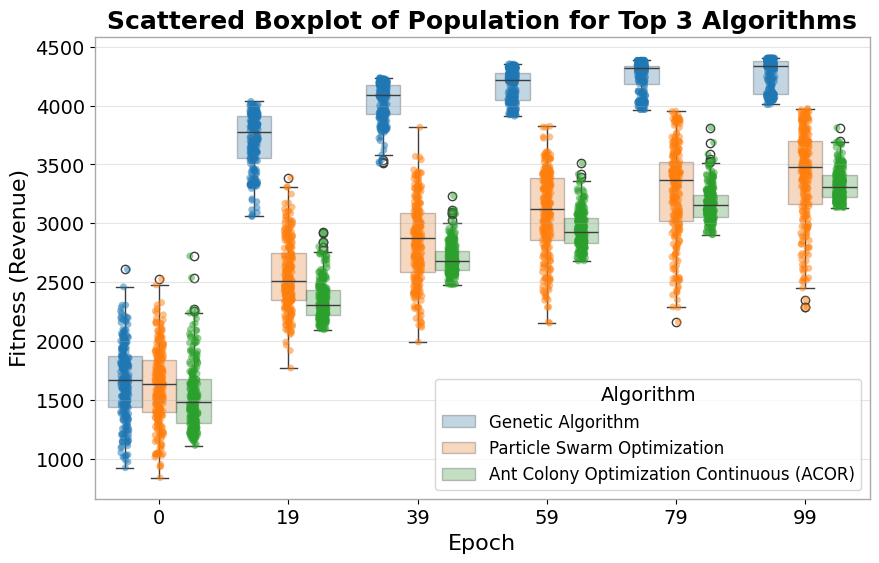

In [45]:
# Filter df, only rows with 'Iteration' values included in [0, .., 49]
df_boxplot_filtered = df_boxplot[df_boxplot['Iteration'].isin([0, 19, 39, 59, 79, 99])]

sns_box_plot(df=df_boxplot_filtered,
             x_data='Iteration',
             y_data='Fitness',
             hue='Algorithm',
             title="Scattered Boxplot of Population for Top 3 Algorithms",
             x_label="Epoch",
             y_label="Fitness (Revenue)",
             save_path=Path('../reports/mealpy/scattered_boxplot_top_3_25.pdf'))

In [21]:
# Table with results by run

sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behavior=revenue_behaviour,
                         line=line,
                         safe_headway=10)

service_tsps = {service.id: service.tsp.name for service in supply.services}
columns = ['Algorithm', 'Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
columns += set(service_tsps.values())

summary_df = pd.DataFrame(columns=columns)

algo_grouped_df = df_history.groupby('Algo')

for algo_group in algo_grouped_df:
    run_grouped_df = algo_group[1].groupby('Run')
    for group in run_grouped_df.groups:
        run = run_grouped_df.get_group(group)['Run'].iloc[-1]
        revenue = np.round(run_grouped_df.get_group(group)['Fitness'].iloc[-1], 2)
        execution_time = np.round(run_grouped_df.get_group(group)['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
        scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
        real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
        sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
        delta_dt = 0.0
        delta_tt = 0.0
        services_by_tsp = {tsp: 0 for tsp in service_tsps.values()}
        for i, service in enumerate(sm.requested_schedule):
            if not scheduled_trains_array[i]:
                continue
            departure_station = list(sm.requested_schedule[service].keys())[0]
            delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                            sm.requested_schedule[service][departure_station][1])
            for j, stop in enumerate(sm.requested_schedule[service].keys()):
                if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                    continue
                delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])
    
            service_tsp = service_tsps[service]
            services_by_tsp[service_tsp] += 1
    
        percentages_by_tsp = {}
        for tsp in services_by_tsp:
            percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100, 2)} %"
        row_data =  [algo_group[0], run, revenue, execution_time, 
                     scheduled_trains, np.round(delta_dt, 2), np.round(delta_tt, 2), *list(percentages_by_tsp.values())]
        summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Revenue', ascending=False)
display(summary_df)
print()

Algorithm  Run  Revenue  \
24                                Genetic Algorithm    5  6226.82   
22                                Genetic Algorithm    3  6211.51   
20                                Genetic Algorithm    1  6036.68   
23                                Genetic Algorithm    4  6019.80   
21                                Genetic Algorithm    2  5984.39   
48                     Whale Optimization Algorithm    4  5249.33   
38                      Particle Swarm Optimization    4  5227.43   
16                           Differential Evolution    2  5091.43   
15                           Differential Evolution    1  5087.58   
47                     Whale Optimization Algorithm    3  5070.57   
36                      Particle Swarm Optimization    2  5015.60   
19                           Differential Evolution    5  5014.14   
45                     Whale Optimization Algorithm    1  4966.33   
17                           Differential Evolution    3  4840.41   
49                     Whale Optimization Algorithm    5  4767.02   
35                      Particle Swarm Optimization    1  4722.97   
46                     Whale Optimization Algorithm    2  4608.73   
18                           Differential Evolution    4  4524.37   
39                      Particle Swarm Optimization    5  4513.56   
37                      Particle Swarm Optimization    3  4387.78   
8                             Artificial Bee Colony    4  4271.25   
0         Ant Colony Optimization Continuous (ACOR)    1  4082.65   
2         Ant Colony Optimization Continuous (ACOR)    3  4069.72   
7                             Artificial Bee Colony    3  4044.75   
27                              Grey Wolf Optimizer    3  4011.52   
9                             Artificial Bee Colony    5  3950.32   
3         Ant Colony Optimization Continuous (ACOR)    4  3928.69   
1         Ant Colony Optimization Continuous (ACOR)    2  3847.71   
6                             Artificial Bee Colony    2  3840.68   
4         Ant Colony Optimization Continuous (ACOR)    5  3780.78   
11  Covariance Matrix Adaptation Evolution Strategy    2  3775.06   
29                              Grey Wolf Optimizer    5  3765.33   
28                              Grey Wolf Optimizer    4  3743.91   
10  Covariance Matrix Adaptation Evolution Strategy    1  3696.21   
5                             Artificial Bee Colony    1  3688.10   
34  Hybrid Grey Wolf - Whale Optimization Algorithm    5  3668.08   
25                              Grey Wolf Optimizer    1  3661.51   
30  Hybrid Grey Wolf - Whale Optimization Algorithm    1  3612.47   
26                              Grey Wolf Optimizer    2  3604.62   
32  Hybrid Grey Wolf - Whale Optimization Algorithm    3  3590.77   
31  Hybrid Grey Wolf - Whale Optimization Algorithm    2  3506.38   
41                              Simulated Annealing    2  3481.33   
14  Covariance Matrix Adaptation Evolution Strategy    5  3439.56   
33  Hybrid Grey Wolf - Whale Optimization Algorithm    4  3407.98   
13  Covariance Matrix Adaptation Evolution Strategy    4  3326.87   
12  Covariance Matrix Adaptation Evolution Strategy    3  3196.91   
40                              Simulated Annealing    1  2983.99   
43                              Simulated Annealing    4  2389.46   
44                              Simulated Annealing    5  2312.85   
42                              Simulated Annealing    3  2042.53   

    Execution Time (s.)  Scheduled Trains  Delta DT (min.)  Delta TT (min.)  \
24                82.17                26            423.0            108.0   
22                80.62                28            380.0            140.0   
20                80.43                28            543.0            130.0   
23                83.63                26            289.0            143.0   
21                80.73                28            387.0            170.0   
48                78.04                23       

In [22]:
summary_df.to_latex()

'\\begin{tabular}{llrrrrrrlllll}\n\\toprule\n & Algorithm & Run & Revenue & Execution Time (s.) & Scheduled Trains & Delta DT (min.) & Delta TT (min.) & RU1 & RU4 & RU5 & RU3 & RU2 \\\\\n\\midrule\n24 & Genetic Algorithm & 5 & 6226.820000 & 82.170000 & 26 & 423.000000 & 108.000000 & 40.0 % & 58.33 % & 58.33 % & 61.54 % & 25.0 % \\\\\n22 & Genetic Algorithm & 3 & 6211.510000 & 80.620000 & 28 & 380.000000 & 140.000000 & 40.0 % & 66.67 % & 66.67 % & 53.85 % & 37.5 % \\\\\n20 & Genetic Algorithm & 1 & 6036.680000 & 80.430000 & 28 & 543.000000 & 130.000000 & 40.0 % & 66.67 % & 58.33 % & 61.54 % & 37.5 % \\\\\n23 & Genetic Algorithm & 4 & 6019.800000 & 83.630000 & 26 & 289.000000 & 143.000000 & 60.0 % & 58.33 % & 58.33 % & 53.85 % & 25.0 % \\\\\n21 & Genetic Algorithm & 2 & 5984.390000 & 80.730000 & 28 & 387.000000 & 170.000000 & 60.0 % & 58.33 % & 58.33 % & 69.23 % & 25.0 % \\\\\n48 & Whale Optimization Algorithm & 4 & 5249.330000 & 78.040000 & 23 & 775.000000 & 76.000000 & 40.0 % & 50.0 % 

In [23]:
# Global status

def get_global_status(df: pd.DataFrame):
    algo_grouped_df = df.groupby('Algo')

    for algo_group in algo_grouped_df:
        run_grouped_df = algo_group[1].groupby('Run')
        
        print(f"Global {algo_group[0]} status:")
        
        # Execution time (mean and std.)
        run_times = run_grouped_df['ExecutionTime'].last()
        print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
        print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')
        
        # Revenue (mean and std.)
        run_revenues = run_grouped_df['Fitness'].last()
        print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')
        
        # Scheduled trains (mean and std.)
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')
        
        max_revenue = sum([sm.revenue[service]['canon'] for service in sm.revenue])
        print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")
        print()
        
get_global_status(df_history)

Global Ant Colony Optimization Continuous (ACOR) status:
	Total execution time: 2.2644 s.
	Execution Time (by run) - Mean: 0.4529 s. - Std: 0.0083 s.
	Revenue - Mean: 3941.9094 - Std: 133.3718
	Scheduled Trains - Mean: 23.0 - Std: 1.0
	Max Revenue: 11321.75 - WARNING!: Scheduling all services could not be feasible

Global Artificial Bee Colony status:
	Total execution time: 8.0624 s.
	Execution Time (by run) - Mean: 1.6125 s. - Std: 0.0238 s.
	Revenue - Mean: 3959.023 - Std: 219.2693
	Scheduled Trains - Mean: 21.0 - Std: 2.0
	Max Revenue: 11321.75 - WARNING!: Scheduling all services could not be feasible

Global Covariance Matrix Adaptation Evolution Strategy status:
	Total execution time: 12.6699 s.
	Execution Time (by run) - Mean: 2.534 s. - Std: 0.3328 s.
	Revenue - Mean: 3486.9234 - Std: 244.3291
	Scheduled Trains - Mean: 21.0 - Std: 1.0
	Max Revenue: 11321.75 - WARNING!: Scheduling all services could not be feasible

Global Differential Evolution status:
	Total execution time: 3.9

In [24]:

def get_global_status_as_dataframe(df: pd.DataFrame):
    algo_grouped_df = df.groupby('Algo')
    
    results = []
    for algo_name, algo_group in algo_grouped_df:
        run_grouped_df = algo_group.groupby('Run')
        
        run_times = run_grouped_df['ExecutionTime'].sum()
        
        run_revenues = run_grouped_df['Fitness'].last()
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        
        result = {
            'Algorithm': algo_name,
            'Mean Execution Time (seconds)': round(run_times.mean(), 2),
            'Std Execution Time (seconds)': round(run_times.std(), 2),
            'Mean Fitness (revenue)': round(run_revenues.mean(), 2),
            'Std Fitness (revenue)': round(run_revenues.std(), 2),
            'Mean Scheduled Trains': int(round(run_trains.mean())),
            'Std Scheduled Trains': int(round(run_trains.std()))
        }
        
        results.append(result)
    
    results_df = pd.DataFrame(results)
    
    # Short by column 'Mean Fitness' 
    results_df = results_df.sort_values(by='Mean Fitness (revenue)', ascending=False).reset_index(drop=True)
    return results_df

results_df = get_global_status_as_dataframe(df_history)
results_df

Algorithm  \
0                                Genetic Algorithm   
1                     Whale Optimization Algorithm   
2                           Differential Evolution   
3                      Particle Swarm Optimization   
4                            Artificial Bee Colony   
5        Ant Colony Optimization Continuous (ACOR)   
6                              Grey Wolf Optimizer   
7  Hybrid Grey Wolf - Whale Optimization Algorithm   
8  Covariance Matrix Adaptation Evolution Strategy   
9                              Simulated Annealing   

   Mean Execution Time (seconds)  Std Execution Time (seconds)  \
0                          81.52                          1.37   
1                          78.28                          0.41   
2                          79.39                          0.91   
3                          79.96                          0.69   
4                         159.61                          1.15   
5                          44.80                          0.34   
6                          78.27                          0.75   
7                          78.04                          0.67   
8                         260.88                         34.55   
9                          79.53                          1.36   

   Mean Fitness (revenue)  Std Fitness (revenue)  Mean Scheduled Trains  \
0                 6095.84                 114.28                     27   
1                 4932.40                 251.40                     19   
2                 4911.59                 239.18                     24   
3                 4773.47                 347.69                     23   
4                 3959.02                 219.27                     21   
5                 3941.91                 133.37                     23   
6                 3757.38                 156.01                     20   
7                 3557.14                 101.64                     20   
8                 3486.92                 244.33                     21   
9                 2642.03                 581.58                     20   

   Std Scheduled Trains  
0                     1  
1                     2  
2                     1  
3                     1  
4                     2  
5                     1  
6                     1  
7                     1  
8                     1  
9                     2

In [25]:
results_df.to_latex()

'\\begin{tabular}{llrrrrrr}\n\\toprule\n & Algorithm & Mean Execution Time (seconds) & Std Execution Time (seconds) & Mean Fitness (revenue) & Std Fitness (revenue) & Mean Scheduled Trains & Std Scheduled Trains \\\\\n\\midrule\n0 & Genetic Algorithm & 81.520000 & 1.370000 & 6095.840000 & 114.280000 & 27 & 1 \\\\\n1 & Whale Optimization Algorithm & 78.280000 & 0.410000 & 4932.400000 & 251.400000 & 19 & 2 \\\\\n2 & Differential Evolution & 79.390000 & 0.910000 & 4911.590000 & 239.180000 & 24 & 1 \\\\\n3 & Particle Swarm Optimization & 79.960000 & 0.690000 & 4773.470000 & 347.690000 & 23 & 1 \\\\\n4 & Artificial Bee Colony & 159.610000 & 1.150000 & 3959.020000 & 219.270000 & 21 & 2 \\\\\n5 & Ant Colony Optimization Continuous (ACOR) & 44.800000 & 0.340000 & 3941.910000 & 133.370000 & 23 & 1 \\\\\n6 & Grey Wolf Optimizer & 78.270000 & 0.750000 & 3757.380000 & 156.010000 & 20 & 1 \\\\\n7 & Hybrid Grey Wolf - Whale Optimization Algorithm & 78.040000 & 0.670000 & 3557.140000 & 101.640000 & 2

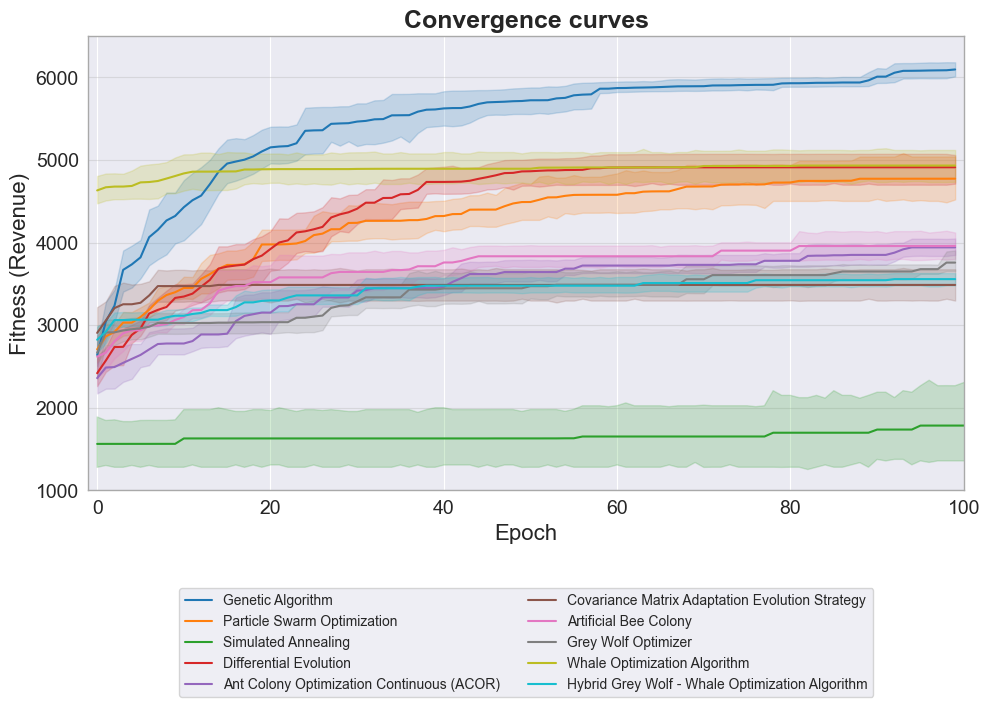

In [27]:
sns_line_plot(df=df_history,
              x_data="Iteration",
              y_data="Fitness",
              hue="Algo",
              title="Convergence curves",
              x_label="Epoch",
              y_label="Fitness (Revenue)",
              x_limit=(-1, 100),
              y_limit=(1000,6500),
              save_path=Path('../reports/mealpy/mealpy_convergence_5_seed.pdf'),
              fig_size=(10, 9))

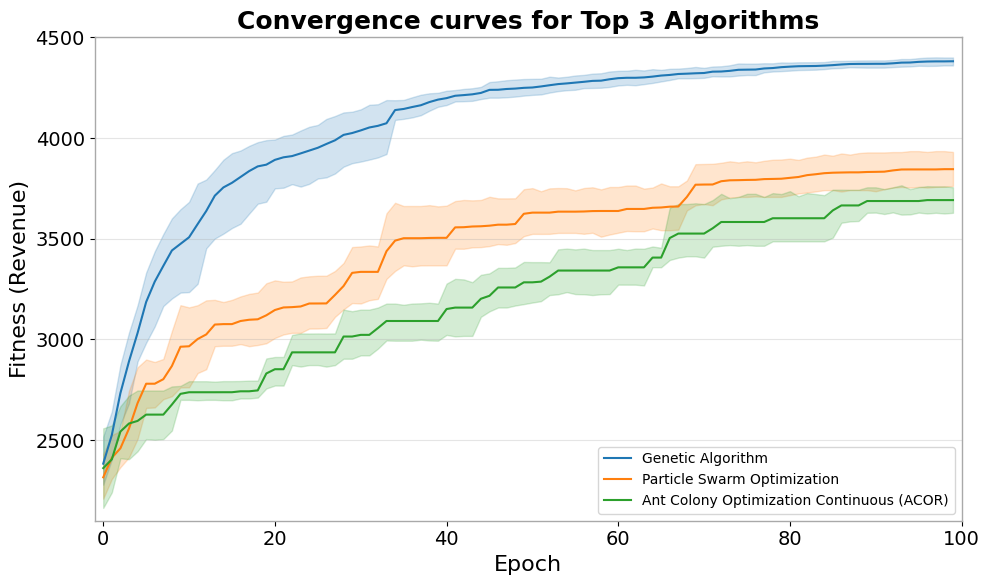

In [52]:
top_3_algos = ("Genetic Algorithm",
               "Particle Swarm Optimization",
               "Ant Colony Optimization Continuous (ACOR)")

# Create dataframe with fitness values for each individual of the population
df_history_top_3 = df_history[df_history['Algo'].isin(top_3_algos)]

sns_line_plot(df=df_history_top_3,
              x_data="Iteration",
              y_data="Fitness",
              hue="Algo",
              title="Convergence curves for Top 3 Algorithms",
              x_label="Epoch",
              y_label="Fitness (Revenue)",
              x_limit=(-1, 100),
              y_limit=(2100,4500),
              save_path=Path('../reports/mealpy/mealpy_convergence_5_seed_top_3.pdf'),
              fig_size=(10, 7))

In [84]:
df_history.head()

Run               Algo  Iteration      Fitness  ExecutionTime  \
0    1  Genetic Algorithm          0  2459.878405       0.246457   
1    1  Genetic Algorithm          1  2460.308339       0.243454   
2    1  Genetic Algorithm          2  2574.487027       0.243266   
3    1  Genetic Algorithm          3  2926.528932       0.239713   
4    1  Genetic Algorithm          4  3015.854710       0.239389   

                                            Discrete  \
0  [False, True, False, True, True, True, True, F...   
1  [False, True, False, True, True, True, True, F...   
2  [False, True, False, True, True, True, True, F...   
3  [False, True, False, True, True, True, True, F...   
4  [False, True, False, True, True, False, True, ...   

                                                Real  Diversity  Exploitation  \
0  [1070, 1114, 1143, 867, 970, 1046, 902, 827, 9...   3.209825      0.000000   
1  [1061, 1109, 1142, 864, 970, 1045, 898, 822, 9...   2.827368     11.915173   
2  [1061, 1109, 1142, 872, 970, 1045, 902, 822, 9...   2.692281     16.123743   
3  [1061, 1109, 1143, 872, 970, 1045, 902, 822, 9...   2.463509     23.250984   
4  [1061, 1109, 1144, 866, 971, 1046, 904, 827, 9...   2.223509     30.728028   

   Exploration  
0   100.000000  
1    88.084827  
2    83.876257  
3    76.749016  
4    69.271972

In [102]:
N = 50  # Número de saltos que quieres aplicar

algo_1_vals = df_history[df_history['Algo'] == 'Simulated Annealing'] \
    .groupby(['Run', 'Iteration'])['Fitness'].last() \
    .groupby(level='Run').apply(lambda x: x.iloc[::N].tolist()).sum()

algo_1_vals

[1741.0809259234882,
 1748.684776735114,
 1776.928458652797,
 1787.0886195088412,
 1789.277000079085,
 1810.0148541336189,
 1819.9926110593465,
 1821.784191284223,
 1959.0674056539915,
 1965.464324500664,
 1974.408813245351,
 1974.408813245351,
 1993.9478517839375,
 1995.1817405334048,
 1995.1817405334048,
 2199.511541491974,
 2203.9916559426238,
 2203.991655942644,
 2210.439801087261,
 2218.9944671113813,
 2218.9944671113813,
 2218.9944671113813,
 2218.9944671113813,
 2221.9108097656595,
 2225.2391621379447,
 2229.040605359691,
 2241.1760454529403,
 2248.2693960385377,
 2526.072256796473,
 2526.2577480508426,
 2526.257748050876,
 2533.5882980193096,
 2533.5882980193096,
 2534.321215424944,
 2536.263289652836,
 2536.9962070584693,
 2536.9962070584693,
 2538.275235491649,
 2558.405138870365,
 2558.405138870365,
 2558.405138870365,
 2558.405138870365,
 2560.428120624755,
 2560.428120624755,
 2564.110568615207,
 2569.815642866672,
 2573.933454008949,
 2575.597474624795,
 2575.597474624795

In [20]:
algo_df = df_history[df_history['Algo'] == 'Genetic Algorithm']

algo_vals = algo_df.groupby(['Iteration'])['Fitness'].max().tolist()

algo_vals

[2607.780704168451,
 2703.21640230218,
 2911.444314465418,
 3103.973183542429,
 3220.667590931876,
 3365.2866137766955,
 3484.48609472132,
 3572.9260730745227,
 3640.073782168727,
 3669.5832622522,
 3705.136185446733,
 3794.5588181089274,
 3839.792800278671,
 3863.719004722367,
 3906.153305799562,
 3960.321202641717,
 3960.321202641717,
 4005.737551227856,
 4021.701509559909,
 4036.1238629427503,
 4036.374965155991,
 4037.255279037032,
 4047.601165890613,
 4072.3073805030704,
 4100.486496755227,
 4102.769254199621,
 4125.723121565449,
 4149.827532752619,
 4172.08849602329,
 4172.08849602329,
 4183.598501918915,
 4194.791579881078,
 4197.818016088964,
 4226.226027636936,
 4226.226027636936,
 4226.226027636936,
 4228.039611525929,
 4228.705076393186,
 4240.677771701874,
 4240.677771701874,
 4253.38097286305,
 4253.38097286305,
 4253.38097286305,
 4256.742944859372,
 4261.969159858364,
 4309.924958575424,
 4310.657875981058,
 4323.559176282795,
 4323.559176282795,
 4323.559176282795,
 432

In [21]:
print(len(algo_vals))

100


In [26]:
algo_df = df_history[df_history['Algo'] == 'Simulated Annealing']

N = 50
algo_vals = algo_df.groupby(algo_df['Iteration'] // N)['Fitness'].max().tolist()

algo_vals

[2121.942526311217,
 2126.1450191909216,
 2153.200797898652,
 2172.1936191864675,
 2174.216600940857,
 2195.3208372725726,
 2204.6153864302687,
 2223.3679354022047,
 2225.390917156595,
 2244.3606160414943,
 2244.3606160414943,
 2247.4535123926985,
 2270.379052946466,
 2270.492084344696,
 2274.816620508482,
 2298.572311796074,
 2316.002237825652,
 2316.002237825652,
 2316.002237825652,
 2320.215221955512,
 2325.565748811522,
 2332.3340863078133,
 2339.717662177076,
 2345.9459463700828,
 2349.005632648977,
 2583.144820693363,
 2590.85225513937,
 2592.3896854296745,
 2596.703525330692,
 2596.703525330692,
 2599.58923714303,
 2623.8452559548505,
 2623.8452559548505,
 2628.9170645467857,
 2630.988554963445,
 2635.5254248523797,
 2649.8720529088614,
 2655.7557863545885,
 2659.9093170072138,
 2660.827594946524,
 2668.118106647075,
 2668.118106647075,
 2671.661031899009,
 2673.3758957005743,
 2673.3758957005743,
 2673.3758957005743,
 2673.3758957005743,
 2673.3758957005743,
 2673.3758957005743

In [27]:
print(len(algo_vals))

100


In [28]:
# Confusion Matrix stadistical differences 

from scipy import stats

def get_epoch_last_fitness(df, name):
    algo_df = df[df['Algo'] == name]
    if name != 'Simulated Annealing':
        algo_vals = algo_df.groupby(['Run', 'Iteration'])['Fitness'].last().groupby(level='Run').apply(list).sum()
    else:
        algo_vals = algo_df.groupby(['Run', 'Iteration'])['Fitness'].last().groupby(level='Run').apply(lambda x: x.iloc[::N].tolist()).sum()
    return algo_vals

def get_epoch_best_fitness(df, name):
    algo_df = df[df['Algo'] == name]
    if name != 'Simulated Annealing':
        algo_vals = algo_df.groupby(['Iteration'])['Fitness'].max().tolist()
    else:
        algo_vals = algo_df.groupby(algo_df['Iteration'] // N)['Fitness'].max().tolist()
    return algo_vals

matrix_wilcoxon = []
matrix_p_values = []
for algo_name, algo in mp_algos.items():
    row_w = []
    row_p = []
    for algo_name_2, algo_2 in mp_algos.items():
        if algo_name == algo_name_2:
            row_w.append(np.nan)
            row_p.append(np.nan)
            continue
        
        algo_1_vals = get_epoch_best_fitness(df_history, algo_name)
        algo_2_vals = get_epoch_best_fitness(df_history, algo_name_2)
        stat, p_value = stats.wilcoxon(algo_1_vals, algo_2_vals)
        row_w.append(round(stat))
        row_p.append(round(p_value, 3))
    matrix_wilcoxon.append(row_w)
    matrix_p_values.append(row_p)

In [29]:
print("Wilcoxon Matrix")
df_wilcoxon = pd.DataFrame(matrix_wilcoxon, index=mp_algos.keys(), columns=mp_algos.keys())
print(df_wilcoxon)

Wilcoxon Matrix
                                                 Genetic Algorithm  \
Genetic Algorithm                                              NaN   
Particle Swarm Optimization                                    0.0   
Simulated Annealing                                            0.0   
Differential Evolution                                         0.0   
Ant Colony Optimization Continuous (ACOR)                      3.0   
Covariance Matrix Adaptation Evolution Strategy               39.0   
Artificial Bee Colony                                          1.0   
Grey Wolf Optimizer                                            0.0   
Whale Optimization Algorithm                                 239.0   
Hybrid Grey Wolf - Whale Optimization Algorithm                0.0   

                                                 Particle Swarm Optimization  \
Genetic Algorithm                                                        0.0   
Particle Swarm Optimization                          

In [30]:
print("P-Values Matrix")
df_p_values = pd.DataFrame(matrix_p_values, index=mp_algos.keys(), columns=mp_algos.keys())
print(df_p_values)

P-Values Matrix
                                                 Genetic Algorithm  \
Genetic Algorithm                                              NaN   
Particle Swarm Optimization                                    0.0   
Simulated Annealing                                            0.0   
Differential Evolution                                         0.0   
Ant Colony Optimization Continuous (ACOR)                      0.0   
Covariance Matrix Adaptation Evolution Strategy                0.0   
Artificial Bee Colony                                          0.0   
Grey Wolf Optimizer                                            0.0   
Whale Optimization Algorithm                                   0.0   
Hybrid Grey Wolf - Whale Optimization Algorithm                0.0   

                                                 Particle Swarm Optimization  \
Genetic Algorithm                                                      0.000   
Particle Swarm Optimization                          

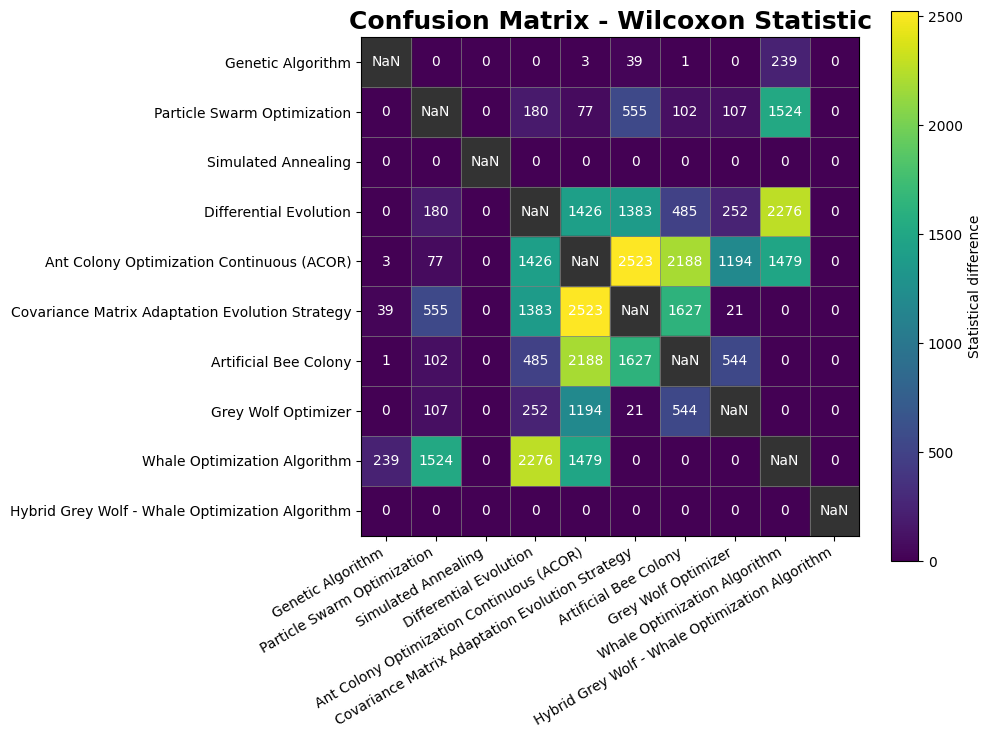

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(df_wilcoxon, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Statistical difference')
plt.xticks(range(10), df_wilcoxon.columns, rotation=30, ha='right')
plt.yticks(range(10), df_wilcoxon.index)
plt.title('Confusion Matrix - Wilcoxon Statistic', fontweight='bold', fontsize=18)

for i in range(df_wilcoxon.shape[0]):
    for j in range(df_wilcoxon.shape[1]):
        value = df_wilcoxon.iloc[i, j]
        if np.isnan(value):
            # Manejo especial para NaN
            display_value = "NaN"
            text_color = 'white'  # Color negro para NaN
            rect_color = (0.2, 0.2, 0.2)  # Gris oscuro
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{int(value)}"
            text_color = 'black' if value > 50000 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color)
        
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/wilcoxon_confusion_matrix_5_seed.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

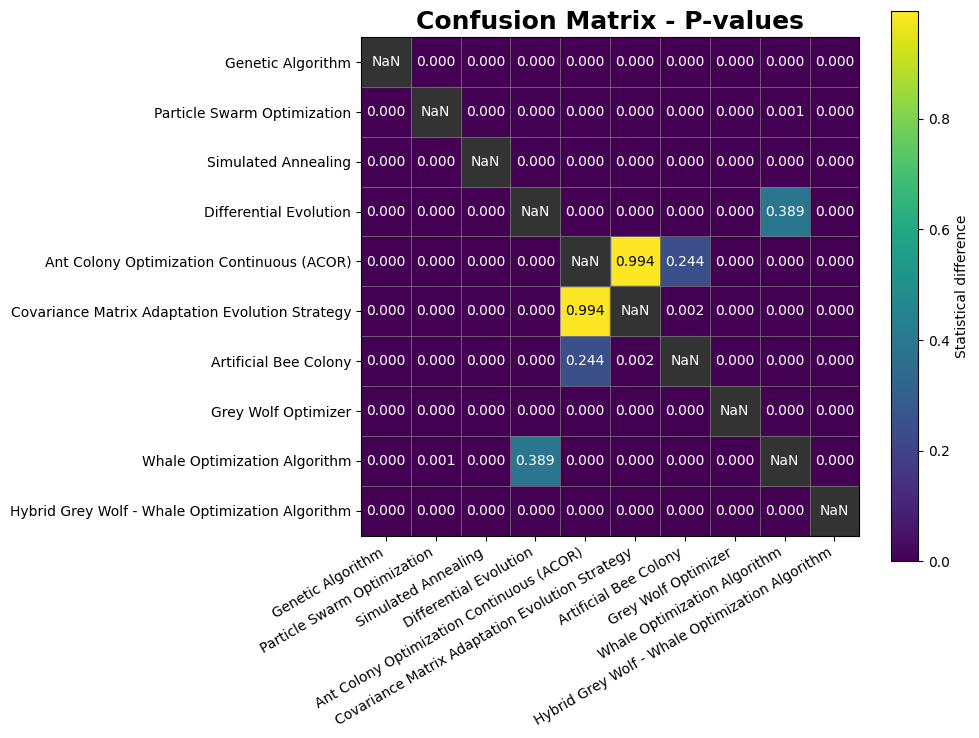

In [33]:
# Visualización con matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(df_p_values, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Statistical difference')
plt.xticks(range(10), df_p_values.columns, rotation=30, ha='right')
plt.yticks(range(10), df_p_values.index)
plt.title('Confusion Matrix - P-values', fontweight='bold', fontsize=18)

for i in range(df_p_values.shape[0]):
    for j in range(df_p_values.shape[1]):
        value = df_p_values.iloc[i, j]
        if np.isnan(value):
            # Manejo especial para NaN
            display_value = "NaN"
            text_color = 'white'  # Color negro para NaN
            rect_color = (0.2, 0.2, 0.2)  # Gris oscuro
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{value:.3f}"
            text_color = 'black' if value > 0.4 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color)
        
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/p_values_confusion_matrix_5_seed.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

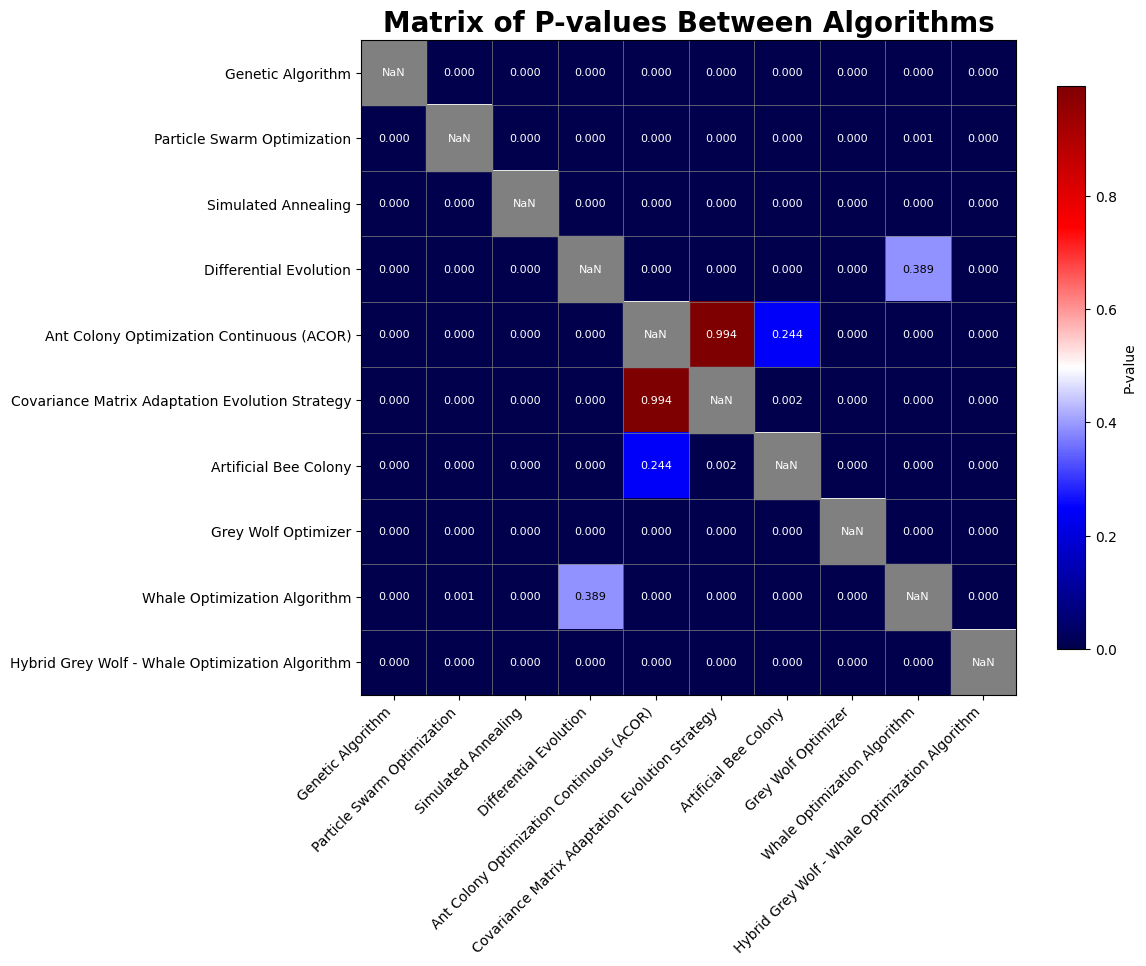

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(12, 10))
plt.imshow(df_p_values, cmap='seismic', interpolation='nearest')
plt.colorbar(label='P-value', shrink=0.8)
plt.xticks(range(df_p_values.shape[1]), df_p_values.columns, rotation=45, ha='right', fontsize=10)
plt.yticks(range(df_p_values.shape[0]), df_p_values.index, fontsize=10)
plt.title('Matrix of P-values Between Algorithms', fontweight='bold', fontsize=20)

for i in range(df_p_values.shape[0]):
    for j in range(df_p_values.shape[1]):
        value = df_p_values.iloc[i, j]
        if np.isnan(value):
            display_value = "NaN"
            text_color = 'white'
            rect_color = (0.5, 0.5, 0.5)
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{value:.3f}"
            text_color = 'black' if value > 0.3 and value < 0.7 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color, fontsize=8)

ax = plt.gca()
ax.set_xticks(np.arange(-0.5, df_p_values.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, df_p_values.shape[0], 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/p_values_confusion_matrix_improved.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [36]:
stat, p_value = stats.wilcoxon(genetic_revenues_mean, acor_revenues_mean)
print(f"Estadístico de Wilcoxon: {stat}, Valor p: {p_value}")

Estadístico de Wilcoxon: 0.0, Valor p: 0.0625


In [37]:
# Select a solution from df_history:
algo_name = 'Genetic Algorithm'
run = 5
iteration = 99

filtered_row = df_history[
    (df_history["Algo"] == algo_name) &
    (df_history["Run"] == run) &
    (df_history["Iteration"] == iteration)
]

# Get values from columns "Real" & "Discrete"
if not filtered_row.empty:
    real_value = filtered_row["Real"].iloc[0]
    discrete_value = filtered_row["Discrete"].iloc[0]
    ga_best_sol = Solution(real=real_value, discrete=discrete_value)
    print(f"Real: {real_value}, Discrete: {discrete_value}")
else:
    print("Row not found matching the provided parameters.")

Real: [1065. 1112. 1142.  873.  972. 1046.  907.  828.  913. 1355.  731.  130.
  210.  271.  479.  531.  630.  693.  930.  748.  177.  399.  463.  506.
  939.  968. 1038. 1094. 1132. 1161. 1188. 1253. 1309. 1345.  422.  466.
  503.  278.  336.  374.  528.  570. 1070. 1190. 1249. 1288.  559.  613.
  649. 1241.  462.  525.  567. 1276.  898.  998. 1060.], Discrete: [False  True False  True  True  True  True False  True False  True  True
  True  True  True False  True False  True  True  True  True  True  True
  True]


In [25]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

services = sm.update_supply(path=generator_save_path,
                            solution=ga_best_sol)

sm.update_schedule(solution=ga_best_sol)

filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if ga_best_sol.discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

#plotter = TrainSchedulePlotter(filtered_services, line)
#plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_gsa'
print(supply_save_path, tt_file_name)
SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)

# Copy previous file in reports
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'gsa/{tt_file_name}_25_new.yml')

supply_config_file = Path(f'{supply_save_path}{tt_file_name}.yml')

../configs/mealpy/ supply_config_gsa


In [26]:
final_supply = Supply.from_yaml(supply_config_file)

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


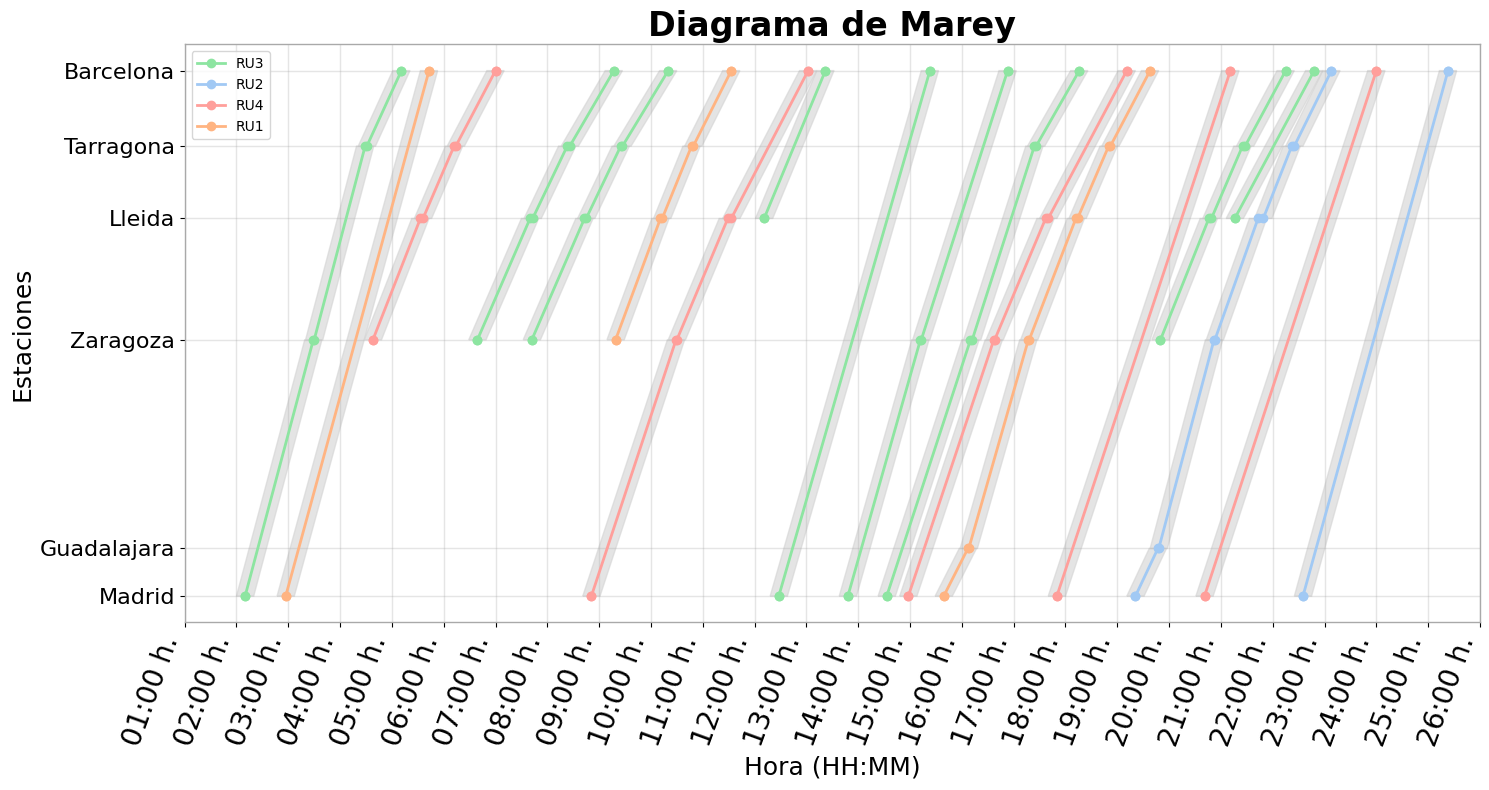

In [27]:
plot_marey_chart(requested_supply=final_supply,
                 colors_by_tsp=True, 
                 main_title="Diagrama de Marey",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/mealpy/marey_chart_ga_25.pdf'))

In [38]:
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'mealpy/{tt_file_name}_25.yml')

PosixPath('../reports/mealpy/supply_config_gsa_25.yml')

In [30]:
#!snakeviz profile.pstat